# Project Notebook

## Title:  Discovery of mRNA Therapeutic Targets in Melanoma Using Single-Cell Transcriptomics and Machine Learning

## Josh Chapman

- Refer to **chapman_dtsc 691_project_readme.txt** for notebook instructions.

In [1]:
# Centralized Import Cell

# Standard Library
import time
import re
from pathlib import Path

# Core Data & Scientific
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scanpy / Single-cell stack
import scanpy as sc
import anndata
import scipy.sparse as sp
import bbknn
import gseapy as gp

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    RocCurveDisplay,
    accuracy_score, average_precision_score, brier_score_loss,
    classification_report, confusion_matrix,
    f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Utilities
import joblib
import shap
import requests
from IPython.display import display


## GSE72056 Dataset - Loading Data for Further Analysis

The GSE72056 dataset (Tirosh et al., 2016) contains single-cell RNA sequencing (scRNA-seq) profiles of ~4,645 cells from 19 melanoma patients. It includes malignant tumor cells, infiltrating immune populations (T cells, B cells, macrophages, NK cells), stromal fibroblasts, and endothelial cells. Expression values are provided as log-transformed TPM, with metadata on patient ID, cell type, and malignancy status. This dataset is widely used as a reference for studying melanoma heterogeneity, tumor–immune interactions, and drug resistance programs.

Link to NCBI:  https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056

In [2]:
# Load the dataset
df_raw = pd.read_csv("Data/GSE72056_melanoma_single_cell_revised_v2.txt", sep="\t", header=None)
df_raw.iloc[:10, :10]  # show first 10 rows × 10 columns


C:\Users\josha\AppData\Local\Temp\ipykernel_21016\3686803924.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

0                        1  \
0                                               Cell  Cy72_CD45_H02_S758_comb   
1                                              tumor                       72   
2                 malignant(1=no,2=yes,0=unresolved)                        1   
3  non-malignant cell type (1=T,2=B,3=Macro.4=End...                        2   
4                                           C9orf152                        0   
5                                              RPS11                   9.2172   
6                                              ELMO2                        0   
7                                            CREB3L1                        0   
8                                              PNMA1                        0   
9                                               MMP2                        0   

                           2                        3  \
0  CY58_1_CD45_B02_S974_comb  Cy71_CD45_D08_S524_comb   
1                         58                       71   
2                          1                        2   
3                          1                        0   
4                          0                        0   
5                     8.3745                    9.313   
6                          0                   2.1263   
7                          0                        0   
8                          0                        0   
9                          0                  0.73812   

                             4                           5  \
0  Cy81_FNA_CD45_B01_S301_comb  Cy80_II_CD45_B07_S883_comb   
1                           81                          80   
2                            2                           2   
3                            0                           0   
4                            0                           0   
5                       7.8876                      8.3291   
6                            0                           0   
7                            0                           0   
8                            0                           0   
9                            0                           0   

                              6                        7  \
0  Cy81_Bulk_CD45_B10_S118_comb  Cy72_CD45_D09_S717_comb   
1                            81                       72   
2                             2                        1   
3                             0                        1   
4                             0                        0   
5                        7.8336                   8.3737   
6                         0.774                        0   
7                             0                        0   
8                             0                        0   
9                             0                        0   

                         8                        9  
0  Cy74_CD45_A03_S387_comb  Cy71_CD45_B05_S497_comb  
1                       74                       71  
2                        1                        2  
3                        1                        0  
4                        0                        0  
5                   8.1338                   8.4373  
6                        0                        0  
7                        0                        0  
8                        0                        0  
9                        0                        0

This code block preprocesses the GSE72056 melanoma single-cell RNA-seq dataset using methods adapted from Tirosh et al., 2016. It imports the raw tab-delimited file, extracts cell identifiers, and reads metadata rows that indicate malignant status and cell type codes, mapping them to descriptive labels such as “tumor” and “T_cell.” A metadata DataFrame is created and indexed by cell IDs. The expression matrix is constructed from the remaining rows, transposed into cells × genes format, and updated to ensure unique gene names. Sanity checks confirm alignment between the 4,645 cells in the expression matrix and metadata, with no missing values in key columns. Both datasets are combined into an AnnData object with an added “dataset” label for downstream Scanpy workflows. Output confirms the object contains 4,645 observations and 23,686 genes, along with annotations for malignant status, cell type, and dataset origin, establishing a structured foundation for normalization, feature selection, and model training in the ML pipeline.

In [3]:
# Extract cell IDs from row 0, skipping the "Cell" label
cell_ids = df_raw.iloc[0, 1:].tolist()

# Extract malignant and cell_type_code metadata from rows 2 and 3
malignant_raw = df_raw.iloc[2, 1:].astype(float)
cell_type_raw = df_raw.iloc[3, 1:].astype(float)

# Map metadata values to descriptive labels
malignant_labels = malignant_raw.map({2: "tumor", 1: "non-tumor", 0: "unresolved"})
cell_type_labels = cell_type_raw.map({
    1: "T_cell", 2: "B_cell", 3: "Macrophage", 4: "Endothelial", 5: "CAF", 0: np.nan
})

# Create metadata DataFrame
metadata_72056 = pd.DataFrame({
    "malignant": malignant_labels.values,
    "cell_type_code": cell_type_labels.values
}, index=cell_ids)

# Extract expression matrix from row 4 onward
gene_names = df_raw.iloc[4:, 0].tolist()
exprs_72056 = df_raw.iloc[4:, 1:].astype(float)
exprs_72056.index = gene_names
exprs_72056.columns = cell_ids
exprs_72056 = exprs_72056.T  # transpose to shape (cells × genes)

# Make gene names unique
def make_unique(names):
    seen = {}
    result = []
    for name in names:
        if name not in seen:
            seen[name] = 0
            result.append(name)
        else:
            seen[name] += 1
            result.append(f"{name}_{seen[name]}")
    return result

exprs_72056.columns = make_unique(exprs_72056.columns)

# Sanity checks
print("Expression shape:", exprs_72056.shape)
print("Metadata shape:", metadata_72056.shape)
print("Index match:", all(exprs_72056.index == metadata_72056.index))
print("Metadata columns with all NaNs:\n", metadata_72056.isna().all())

# Create AnnData object
adata_72056 = sc.AnnData(exprs_72056)
adata_72056.obs = metadata_72056
adata_72056.obs["dataset"] = "GSE72056"

# Confirm structure
print(adata_72056)


Expression shape: (4645, 23686)
Metadata shape: (4645, 2)
Index match: True
Metadata columns with all NaNs:
 malignant         False
cell_type_code    False
dtype: bool
AnnData object with n_obs × n_vars = 4645 × 23686
    obs: 'malignant', 'cell_type_code', 'dataset'


This code block performs exploratory data analysis on the GSE72056 melanoma dataset by summarizing both metadata and gene expression patterns, then visualizing key distributions. The metadata summary shows that out of 4,645 annotated cells, malignancy status has three categories, non-tumor (3,256 cells), tumor (approximately 1,300 cells), and unresolved (small minority). Cell type annotations are available for 2,835 cells, with five categories represented; T cells dominate (2,068 cells), followed by B cells, macrophages, CAFs, and endothelial cells. Expression-level statistics for 23,686 genes indicate an average gene mean expression of 0.46 with a standard deviation of 0.81, while average per-gene variability (std) is 0.78, showing considerable heterogeneity in expression across cells. The plots highlight the skew toward T cells in the cell type distribution and the large predominance of non-tumor cells in the malignancy distribution, providing a clear baseline view of sample composition and variability before further analysis.


malignant cell_type_code
count        4645           2835
unique          3              5
top     non-tumor         T_cell
freq         3256           2068

mean           std
count  23686.000000  23686.000000
mean       0.464447      0.776701
std        0.805820      0.663412
min        0.000000      0.000000
25%        0.014900      0.204414
50%        0.155000      0.611455
75%        0.615434      1.194534
max       12.510287      4.113740

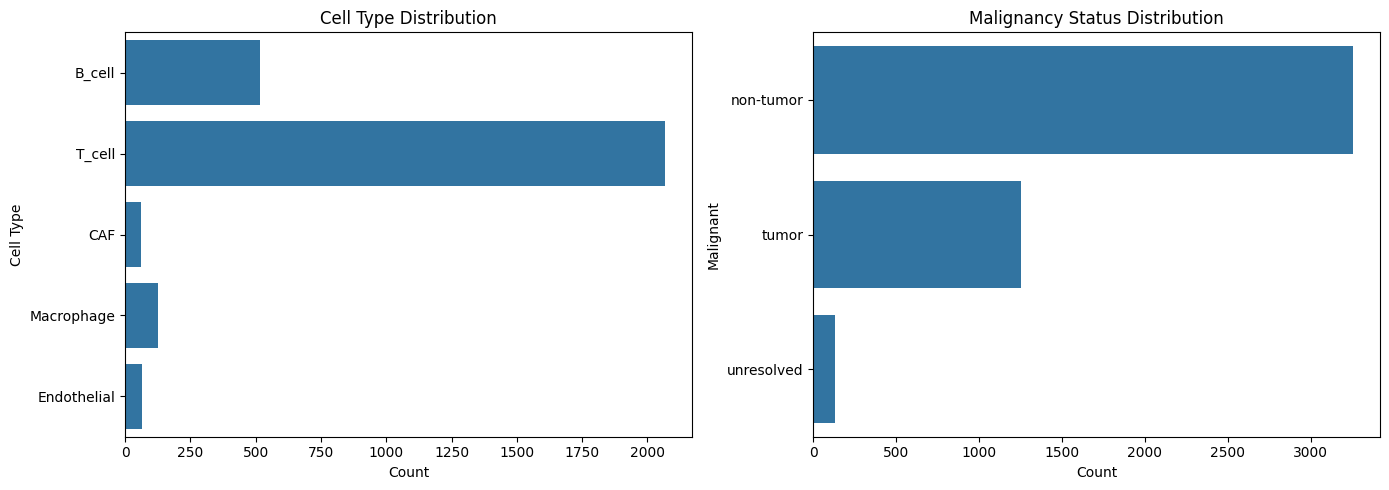

In [4]:

# Summary statistics for metadata
metadata_summary = metadata_72056.describe(include="all")

# Count of cell types and malignancy labels
cell_type_counts = metadata_72056["cell_type_code"].value_counts(dropna=False)
malignant_counts = metadata_72056["malignant"].value_counts(dropna=False)

# Expression stats (mean, std) across all genes
exprs_summary = exprs_72056.describe().T[["mean", "std"]].describe()

# Visualizations
plt.figure(figsize=(14, 5))

# Plot 1: Cell type distribution
plt.subplot(1, 2, 1)
sns.countplot(y=metadata_72056["cell_type_code"])
plt.title("Cell Type Distribution")
plt.xlabel("Count")
plt.ylabel("Cell Type")

# Plot 2: Malignant vs Non-tumor
plt.subplot(1, 2, 2)
sns.countplot(y=metadata_72056["malignant"])
plt.title("Malignancy Status Distribution")
plt.xlabel("Count")
plt.ylabel("Malignant")

plt.tight_layout()

# Display summaries
from IPython.display import display
display(metadata_summary)
display(exprs_summary)

plt.show()


This code block applies dimensionality reduction and visualization techniques to the GSE72056 melanoma single-cell dataset, followed by an exploration of gene expression patterns by malignancy status. First, the data is scaled and principal component analysis (PCA) is performed to reduce dimensionality, then a neighborhood graph is computed, and Uniform Manifold Approximation and Projection (UMAP) is applied for non-linear embedding. The PCA plots show cell separation trends when colored by malignancy status and cell type, with partial segregation of tumor and non-tumor populations along the first two principal components. The UMAP plots reveal clearer clustering, with distinct malignant and non-malignant groups, and tighter grouping of certain immune and stromal cell types. Finally, violin plots display expression distributions of three example genes across malignancy categories, highlighting differences in both expression levels and variability between tumor, non-tumor, and unresolved cell populations. Together, these outputs provide both a global view of dataset structure and an initial look at marker gene variation across cell states.

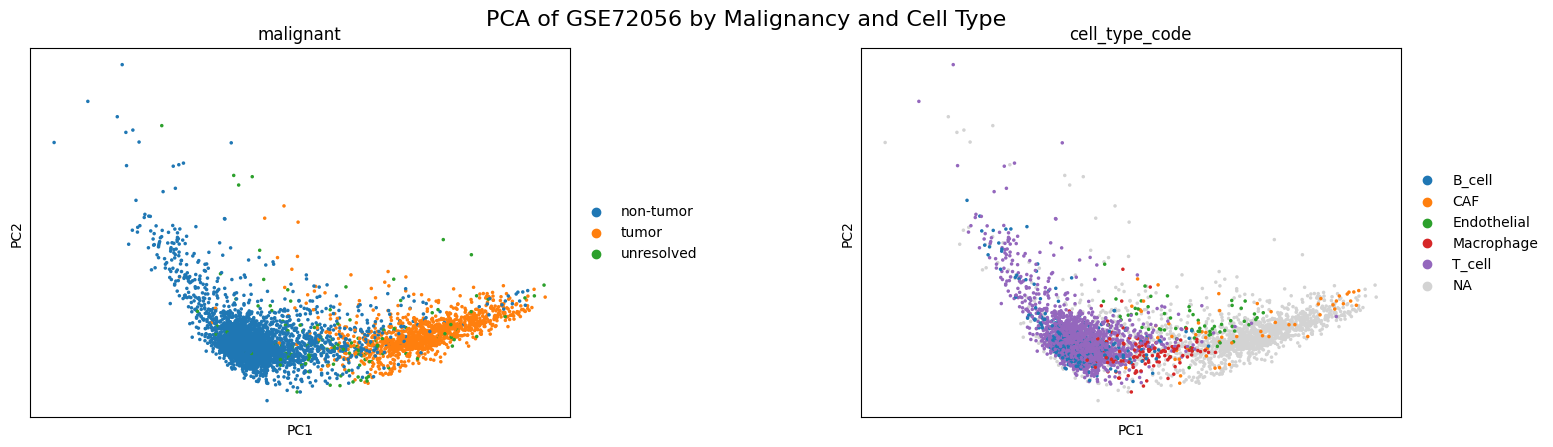

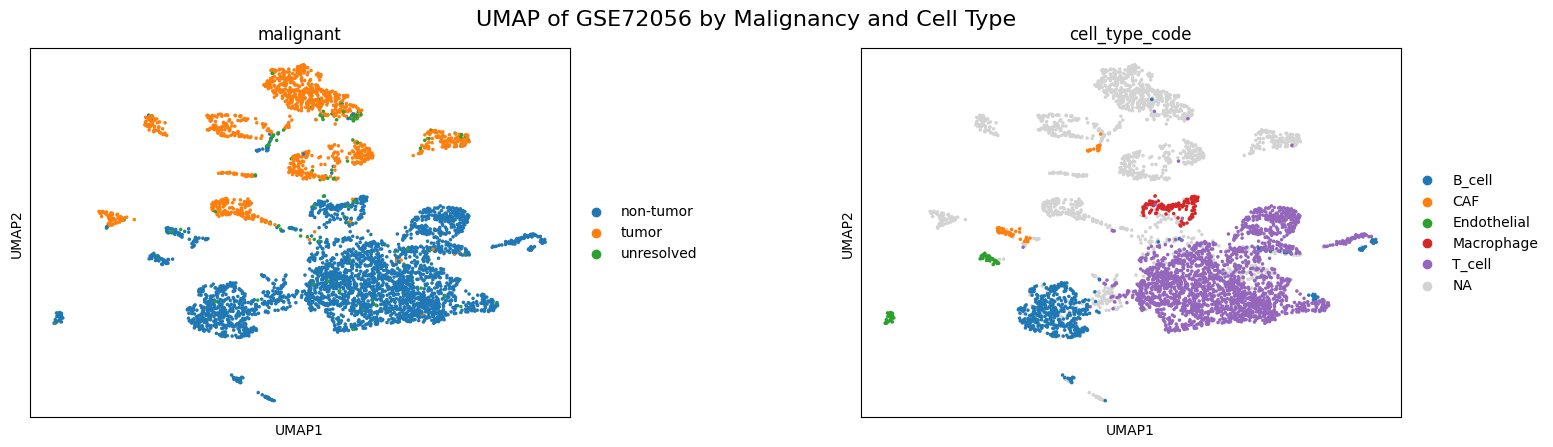

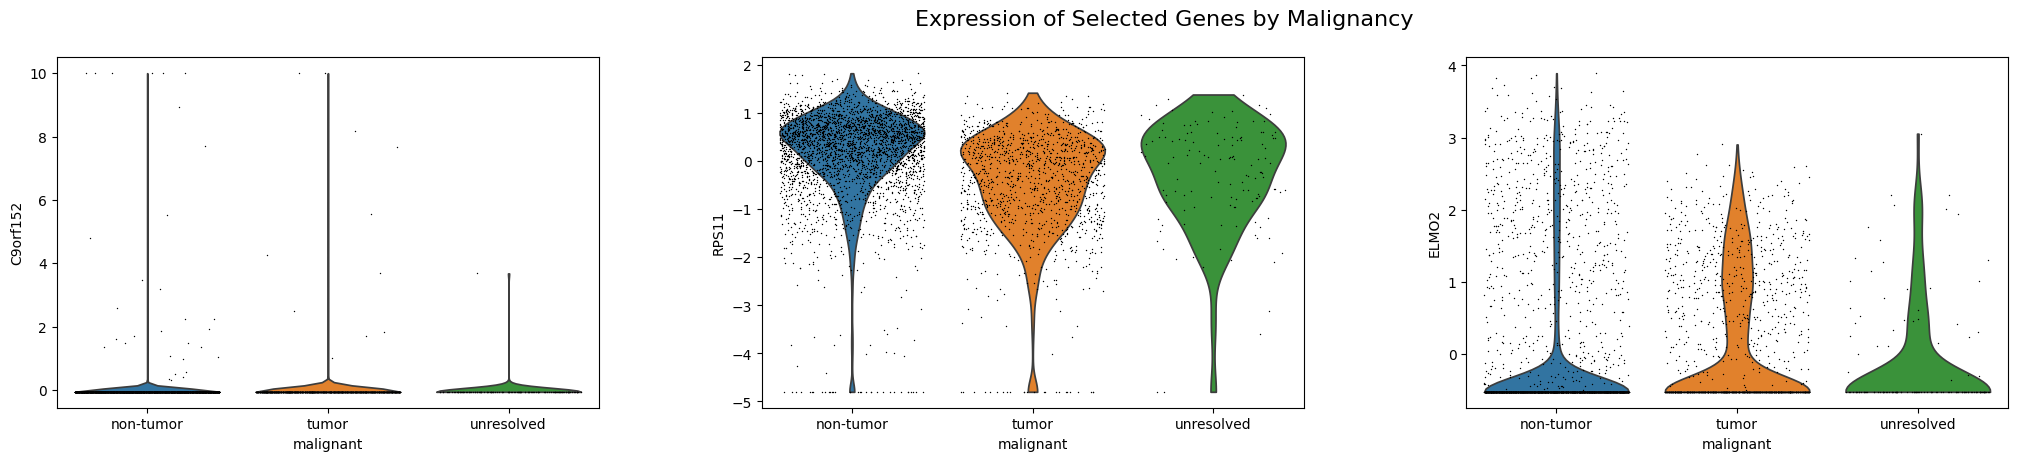

In [5]:
# Compute PCA on scaled data
sc.pp.scale(adata_72056, max_value=10)
sc.tl.pca(adata_72056, svd_solver='arpack')

# Compute neighborhood graph and UMAP
sc.pp.neighbors(adata_72056, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_72056)

# PCA plot with titles
sc.pl.pca(adata_72056, color=['malignant', 'cell_type_code'], wspace=0.4, show=False)
plt.suptitle("PCA of GSE72056 by Malignancy and Cell Type", fontsize=16)
plt.show()

# UMAP plot with titles
sc.pl.umap(adata_72056, color=['malignant', 'cell_type_code'], wspace=0.4, show=False)
plt.suptitle("UMAP of GSE72056 by Malignancy and Cell Type", fontsize=16)
plt.show()

# Violin plots of selected gene expression by malignancy status
selected_genes = adata_72056.var_names[:3]  # take first 3 genes for demo
sc.pl.violin(adata_72056, keys=selected_genes, groupby='malignant', jitter=0.4, show=False)
plt.suptitle("Expression of Selected Genes by Malignancy", fontsize=16)
plt.show()



The analysis begins by generating a differential-expression dataset from the GSE72056 single-cell RNA-seq melanoma collection. A new copy of the AnnData object is created, and cells are categorized into two groups based on the malignant label: malignant cells are assigned as “tumor” and non-malignant cells as “immune,” while unresolved entries are excluded. This produces group sizes of 3,256 immune cells and 1,257 tumor cells. To control noise and reduce memory requirements, the dataset is restricted to the 5,000 most variable genes using the Seurat flavor of highly variable gene detection. The data matrix is then densified and adjusted with a small epsilon to prevent undefined values during log2 transformations. Differential expression is computed using Scanpy’s t-test_overestim_var, which is robust for sparse single-cell data. The results are assembled into a tidy DataFrame with log2 fold changes, adjusted p-values, test statistics, and detection fractions for each group. The strongest tumor-associated markers include CPAMD8 (log2FC ≈ 11.0, adj. p ≈ 0.009), TENM2 (≈ 8.7, 0.015), GUSBP10 (≈ 8.5, 0.012), TMEM244 (≈ 8.3, 0.009), and CD177 (≈ 7.3, 0.005), while PSG8 and CCM2L show large fold changes but weak statistical support. On the immune side, PIANP (≈ 9.4, adj. p ≈ 0.11) and TSPAN8 (≈ 6.9, 0.036) are among the top candidates, along with NKX6-1 and MIR4653, though several have marginal or nonsignificant adjusted values. Scanpy emits runtime warnings about invalid values in log2 calculations, indicating zero-expression genes despite the epsilon adjustment. Overall, the results reveal strong tumor-enriched expression patterns, while immune-associated enrichments are present but more variable and statistically modest.

In [6]:
# Create a copy of the AnnData object for differential expression analysis
adata_de = adata_72056.raw.to_adata() if adata_72056.raw is not None else adata_72056.copy()

# Tumor vs immune grouping, drop unresolved, and create categorical group
mal = adata_de.obs['malignant'].astype(str).str.lower()
grp = pd.Series(pd.NA, index=adata_de.obs_names, dtype="string")
grp.loc[mal == 'tumor'] = 'tumor'
grp.loc[mal == 'non-tumor'] = 'immune'
keep = grp.notna()
adata_de = adata_de[keep].copy()
adata_de.obs['cell_group'] = pd.Categorical(grp[keep].astype(str), categories=['tumor','immune'])
print("Group sizes:", adata_de.obs['cell_group'].value_counts().to_dict())

# Focus on HVGs to cut noise (and RAM) before densifying
sc.pp.highly_variable_genes(adata_de, n_top_genes=5000, flavor="seurat")
adata_de = adata_de[:, adata_de.var['highly_variable']].copy()

# Densify + epsilon so zeros don’t trigger log2 warnings
if sp.issparse(adata_de.X):
    adata_de.X = adata_de.X.toarray()
adata_de.X = adata_de.X.astype(np.float32) + 1e-6 

# Differential expression
sc.tl.rank_genes_groups(
    adata_de,
    groupby='cell_group',
    method='t-test_overestim_var',
    pts=True,
    tie_correct=True
)

# Differential expression DataFrame
res = adata_de.uns['rank_genes_groups']
groups = res['names'].dtype.names
dfs = []
for g in groups:
    dfs.append(pd.DataFrame({
        'gene': res['names'][g],
        'log2fc': res['logfoldchanges'][g],
        'pval_adj': res['pvals_adj'][g],
        'score': res['scores'][g],
        'pct_in_group': res['pts'][g] if 'pts' in res else np.nan,
        'pct_out_group': res['pts_rest'][g] if 'pts_rest' in res else np.nan,
        'group': g
    }))
de_df = pd.concat(dfs, ignore_index=True).dropna(subset=['log2fc'])

# Print top markers
print("\nTop tumor markers:")
print(de_df.query("group=='tumor'").nlargest(10, 'log2fc')[['gene','log2fc','pval_adj']])
print("\nTop immune markers:")
print(de_df.query("group=='immune'").nlargest(10, 'log2fc')[['gene','log2fc','pval_adj']])


Group sizes: {'immune': 3256, 'tumor': 1257}

Top tumor markers:
           gene     log2fc  pval_adj
3917     CPAMD8  10.968397  0.009003
3503       PSG8   8.946905  0.200950
3878      TENM2   8.724717  0.014849
3893    GUSBP10   8.478952  0.012170
3914    TMEM244   8.277904  0.009411
3805    FAM201A   7.515088  0.040709
2043      CCM2L   7.452648  1.000000
3940      CD177   7.290389  0.005046
3848      CCDC3   7.077395  0.025542
3904  LOC400456   6.882714  0.010410

Top immune markers:
           gene    log2fc  pval_adj
8751      PIANP  9.422043  0.111041
8852     TSPAN8  6.942724  0.036337
8511      GATA2  6.859538  0.361746
8731      KLK14  6.329341  0.137877
8709    PABPC4L  5.608447  0.147379
8859     NKX6-1  5.403306  0.031816
8769  LINC00640  5.346597  0.092401
7947    MIR5699  5.270111  1.000000
8767     PRDM12  5.014259  0.094536
8916    MIR4653  4.984027  0.010528


c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


The code generates a volcano plot to visualize differential expression results between tumor and immune groups in the GSE72056 dataset. It begins by computing the negative log10 of the adjusted p-values (FDR), which emphasizes the most statistically significant genes. Thresholds are set at log2 fold change greater than ±1 and FDR < 0.05 to highlight meaningful contrasts. Each gene is plotted according to its log2 fold change (x-axis) and –log10(FDR) (y-axis). Genes that are significantly tumor-enriched (positive fold change, low FDR) are shown in red, while those that are significantly immune-enriched (negative fold change, low FDR) are shown in blue; all other genes are displayed in grey.

The top ten most significant hits are labeled directly on the plot, including strong immune-biased markers like CD177, CPAMD8, TMEM244, and others, which cluster on the left side with large negative fold changes. On the right side, tumor-enriched markers appear in red, though fewer reach high –log10(FDR) values compared to the immune side. The dashed vertical lines mark the fold-change thresholds, while the horizontal line marks the significance cutoff at FDR = 0.05.

The resulting volcano plot clearly illustrates the asymmetry in results: immune-associated genes dominate with stronger statistical support and larger fold changes, while tumor-associated enrichments are present but more modest in both number and significance. This visualization highlights the genes most likely to differentiate tumor from immune cells and provides a compact way to prioritize candidates for further biological validation.

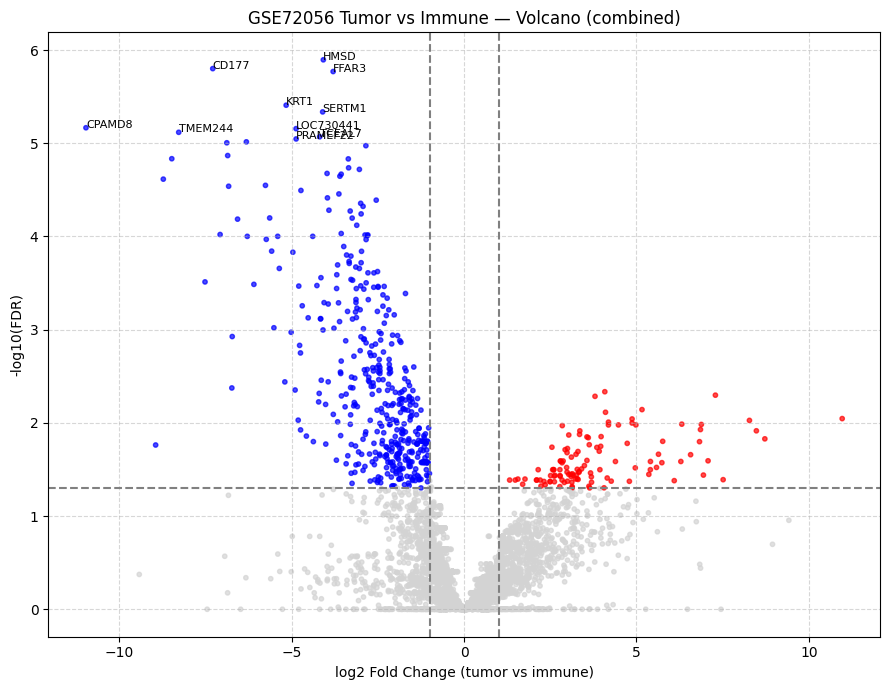

In [7]:
# Copy DE results and compute –log10(FDR)
volcano_df = de_df.copy()
volcano_df["neg_log10_pval"] = -np.log10(volcano_df["pval_adj"].replace(0, np.nextafter(0, 1)))

# Set thresholds
fc_thresh = 1
pval_thresh = 0.05

# Volcano colors
colors = []
for i, row in volcano_df.iterrows():
    if row["log2fc"] > fc_thresh and row["pval_adj"] < pval_thresh:
        colors.append("red")   # tumor-enriched
    elif row["log2fc"] < -fc_thresh and row["pval_adj"] < pval_thresh:
        colors.append("blue")  # immune-enriched
    else:
        colors.append("lightgrey")

# Plot
plt.figure(figsize=(9, 7))
plt.scatter(volcano_df["log2fc"], volcano_df["neg_log10_pval"], 
            c=colors, alpha=0.7, s=10)

# Annotate top hits by significance
top_hits = volcano_df.nsmallest(10, "pval_adj")
for _, row in top_hits.iterrows():
    plt.text(row["log2fc"], row["neg_log10_pval"], row["gene"], fontsize=8)

# Threshold lines
plt.axvline(x=fc_thresh, linestyle="--", color="grey")
plt.axvline(x=-fc_thresh, linestyle="--", color="grey")
plt.axhline(y=-np.log10(pval_thresh), linestyle="--", color="grey")

# Title and labels
plt.title("GSE72056 Tumor vs Immune — Volcano (combined)")
plt.xlabel("log2 Fold Change (tumor vs immune)")
plt.ylabel("-log10(FDR)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## GSE115978 Dataset - Loading Data for Further Analysis

The GSE115978 dataset (Jerby-Arnon et al., 2018) contains single-cell RNA sequencing (scRNA-seq) profiles of ~7,000 cells derived from 33 melanoma tumors across 31 patients. It includes malignant cells as well as diverse non-malignant populations such as T cells, B cells, NK cells, macrophages, cancer-associated fibroblasts, and endothelial cells. Expression values are provided as log-transformed TPM, with accompanying metadata on patient ID, tumor type, and treatment context. This dataset is notable for identifying transcriptional programs of immune evasion, including a malignant cell state associated with T cell exclusion and resistance to immune checkpoint blockade. It serves as a valuable resource for studying tumor–immune interactions, mechanisms of immunotherapy resistance, and the broader melanoma micro-environment.

NCBI link:  https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115978

In [8]:
# Load the GSE115978 counts file with headers
df_raw = pd.read_csv("Data/GSE115978_counts.csv.gz", sep=",", header=0, index_col=0)

# Display the top-left corner of the data
df_raw.iloc[:10, :10]


cy78_CD45_neg_1_B04_S496_comb  \
C9orf152                                  0   
RPS11                                   370   
ELMO2                                    43   
CREB3L1                                   0   
PNMA1                                    68   
MMP2                                     12   
TMEM216                                  15   
TRAF3IP2-AS1                              1   
LRRC37A5P                                 0   
LOC653712                                 0   

              cy79_p4_CD45_neg_PDL1_neg_E11_S1115_comb  CY88_5_B10_S694_comb  \
C9orf152                                             0                     0   
RPS11                                                1                    75   
ELMO2                                                0                     2   
CREB3L1                                              0                     0   
PNMA1                                                0                     1   
MMP2                                                 0                     0   
TMEM216                                              0                     0   
TRAF3IP2-AS1                                         0                     7   
LRRC37A5P                                            0                     0   
LOC653712                                            0                     0   

              cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_F07_S67_comb  \
C9orf152                                                    0   
RPS11                                                      15   
ELMO2                                                      18   
CREB3L1                                                     0   
PNMA1                                                       8   
MMP2                                                        0   
TMEM216                                                     0   
TRAF3IP2-AS1                                                1   
LRRC37A5P                                                   0   
LOC653712                                                   0   

              cy78_CD45_neg_3_H06_S762_comb  \
C9orf152                                  0   
RPS11                                   345   
ELMO2                                    43   
CREB3L1                                   0   
PNMA1                                   103   
MMP2                                     92   
TMEM216                                  16   
TRAF3IP2-AS1                              2   
LRRC37A5P                                 0   
LOC653712                                 0   

              cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_G01_S73_comb  \
C9orf152                                                    0   
RPS11                                                      13   
ELMO2                                                       4   
CREB3L1                                                     0   
PNMA1                                                       8   
MMP2                                                        0   
TMEM216                                                     0   
TRAF3IP2-AS1                                                0   
LRRC37A5P                                                   0   
LOC653712                                                   0   

              cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_D09_S141_comb  \
C9orf152                                                     0   
RPS11                                                        5   
ELMO2                                                        4   
CREB3L1                                                      0   
PNMA1                                                        0   
MMP2                                                         0   
TMEM216                                                      0   
TRAF3IP2-AS1                                                 2   
LRRC37A5P                                                    0   
LOC65

This code block loads and prepares the GSE115978 melanoma scRNA-seq dataset for analysis by integrating cell metadata with TPM gene expression values into an AnnData object. It first reads in cell annotations and the gene expression matrix, aligns the two by their shared cell identifiers, and transposes the expression matrix so that cells are represented as observations and genes as variables. Metadata fields are standardized for consistency, including renaming columns for sample ID, cell type, treatment status, and cohort, and adding a dataset identifier. Sanity checks confirm that the resulting dataset contains 7,186 cells and 23,686 genes, with metadata previews showing cell type (e.g., malignant), treatment groups (post-treatment, treatment-naive), cohort source, and sequencing metrics. The expression preview demonstrates typical sparse single-cell data with varying TPM values across genes, ready for downstream analysis.


In [9]:
# Load cell annotations (metadata)
cell_meta_115978 = pd.read_csv("Data/GSE115978_cell.annotations.csv.gz", index_col=0)

# Load TPM gene expression matrix
tpm_115978 = pd.read_csv("Data/GSE115978_tpm.csv.gz", index_col=0)

# Align cells across metadata and expression matrix
shared_cells = cell_meta_115978.index.intersection(tpm_115978.columns)
cell_meta_115978 = cell_meta_115978.loc[shared_cells]
tpm_115978 = tpm_115978[shared_cells]

# Transpose TPM matrix to match AnnData format (obs = cells, var = genes)
adata_115978 = sc.AnnData(tpm_115978.T)

# Add metadata to AnnData obs
adata_115978.obs = cell_meta_115978.copy()

# Standardize/rename obs columns for consistency
adata_115978.obs.rename(columns={
    'samples': 'sample_id',
    'cell.types': 'cell_type',
    'treatment.group': 'treatment',
    'Cohort': 'cohort'
}, inplace=True)

# Annotate dataset ID
adata_115978.obs['dataset'] = 'GSE115978'

# Sanity checks
print("AnnData shape:", adata_115978.shape)
print("Metadata preview:")
print(adata_115978.obs.head())
print("\nExpression preview:")
print(adata_115978.X[:5, :5])



AnnData shape: (7186, 23686)
Metadata preview:
                                                sample_id cell_type  \
cy78_CD45_neg_1_B04_S496_comb                       Mel78       Mal   
cy79_p4_CD45_neg_PDL1_neg_E11_S1115_comb            Mel79       Mal   
CY88_5_B10_S694_comb                                Mel88       Mal   
cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_F07_S67_comb     Mel79       Mal   
cy78_CD45_neg_3_H06_S762_comb                       Mel78       Mal   

                                                       treatment  cohort  \
cy78_CD45_neg_1_B04_S496_comb                     post.treatment  Tirosh   
cy79_p4_CD45_neg_PDL1_neg_E11_S1115_comb         treatment.naive  Tirosh   
CY88_5_B10_S694_comb                              post.treatment  Tirosh   
cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_F07_S67_comb  treatment.naive  Tirosh   
cy78_CD45_neg_3_H06_S762_comb                     post.treatment  Tirosh   

                                                 no.of.genes  no.of.r

This code block generates summary statistics and visualizations for the GSE115978 dataset’s metadata. The statistical summary confirms that the dataset contains 7,186 cells from 32 unique samples across 10 annotated cell types, two treatment groups, and two cohorts. The most frequent sample is *Mel79* (894 cells), the dominant cell type is malignant (*Mal*, 2,018 cells), the most common treatment group is treatment-naive (3,630 cells), and the majority of cells are from the *Tirosh* cohort (4,199 cells). On average, cells have \~4,577 detected genes and \~465,877 mapped reads. The first bar plot shows the cell type distribution, with malignant cells most abundant, followed by CD8+ T cells, CD4+ T cells, B cells, and other immune/stromal types, while macrophages, CAFs, endothelial cells, and NK cells are less frequent. The second bar plot depicts the treatment group distribution, which is nearly balanced between treatment-naive and post-treatment groups. Together, these outputs provide a detailed overview of the dataset’s composition, technical metrics, and experimental grouping before downstream analysis.


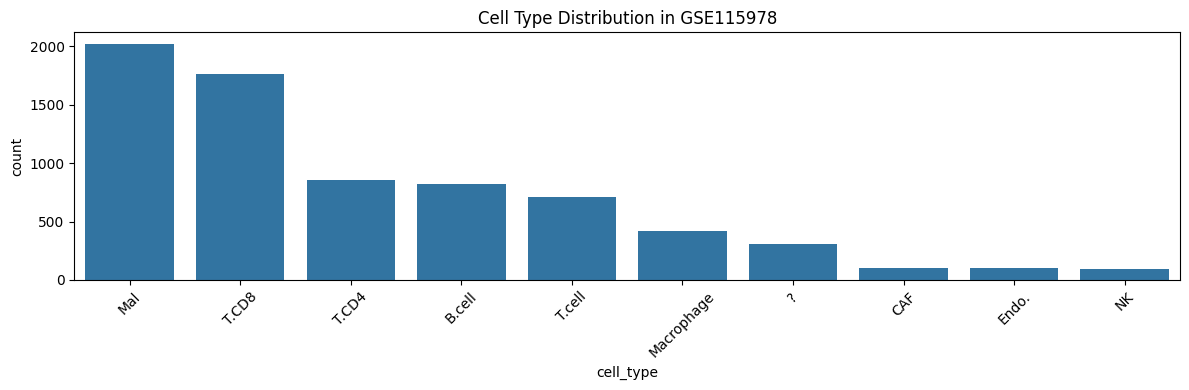

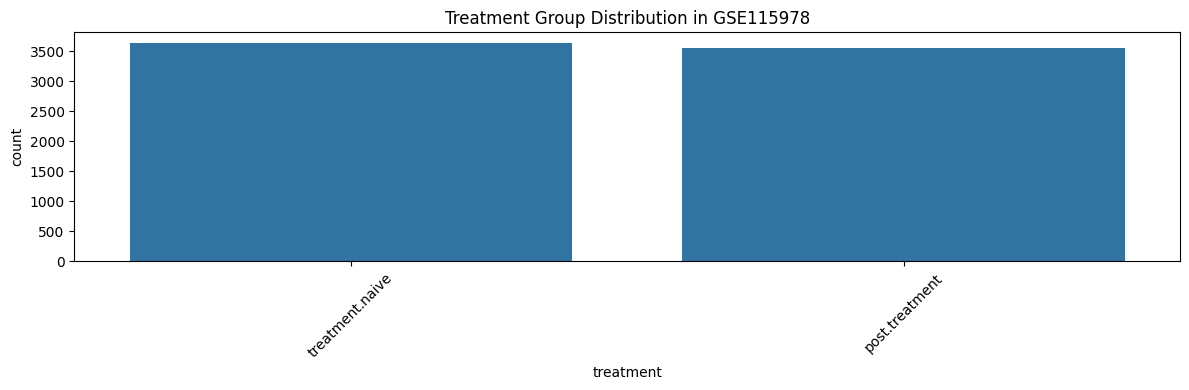

sample_id cell_type        treatment  cohort  no.of.genes  \
count       7186      7186             7186    7186  7186.000000   
unique        32        10                2       2          NaN   
top        Mel79       Mal  treatment.naive  Tirosh          NaN   
freq         894      2018             3630    4199          NaN   
mean         NaN       NaN              NaN     NaN  4577.333565   

          no.of.reads    dataset  
count     7186.000000       7186  
unique            NaN          1  
top               NaN  GSE115978  
freq              NaN       7186  
mean    465877.428611        NaN

In [10]:
# Metadata stats
metadata_summary = adata_115978.obs.describe(include='all')

# Bar plot: Cell Type Distribution
plt.figure(figsize=(12, 4))
sns.countplot(data=adata_115978.obs, x="cell_type", order=adata_115978.obs["cell_type"].value_counts().index)
plt.title("Cell Type Distribution in GSE115978")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot: Treatment Group Distribution
plt.figure(figsize=(12, 4))
sns.countplot(data=adata_115978.obs, x="treatment", order=adata_115978.obs["treatment"].value_counts().index)
plt.title("Treatment Group Distribution in GSE115978")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display summary
metadata_summary.head()


This block preprocesses the GSE115978 scRNA‑seq data and maps its structure with PCA/UMAP, then inspects a few marker‐level patterns. After converting the matrix to float, it selects the top 2,000 highly variable genes (Seurat flavor), scales them, runs PCA, builds a neighbor graph, and computes a UMAP embedding. The PCA/UMAP colored by cell type show clear, well‑formed clusters (e.g., Malignant cells form multiple islands; B cells, CD4/8 T cells, macrophages, CAFs, endothelial cells, NK each occupy distinct regions), indicating strong biology in the HVG space. Coloring by treatment (treatment‑naive vs post‑treatment) reveals substantial mixing across both PCA and UMAP, suggesting treatment status is not the dominant source of variance compared to cell identity. Violin plots for three example genes illustrate cell‑type‑specific expression: one gene (e.g., MMP2) is enriched in stromal/CAF/endothelial compartments with low levels in most immune cells; another shows sparse, near‑zero expression across types; and a third exhibits a modest, more restricted signal (notably in CD4 T cells). Overall, the outputs confirm good separation by cell identity, minimal embedding bias by treatment, and heterogeneous gene expression consistent with expected tumor microenvironment biology.


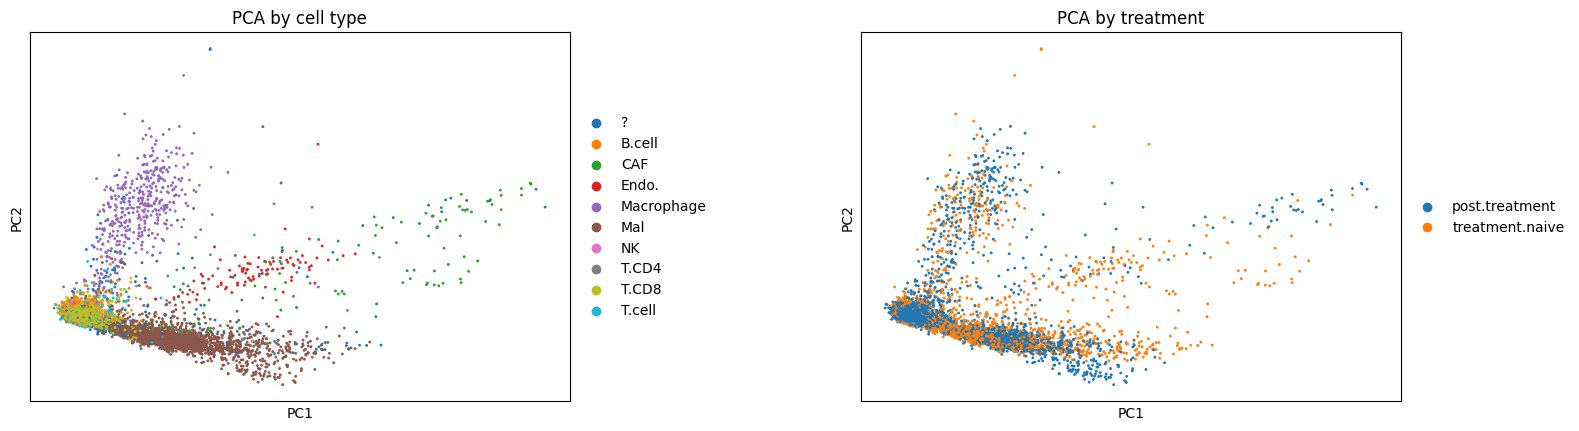

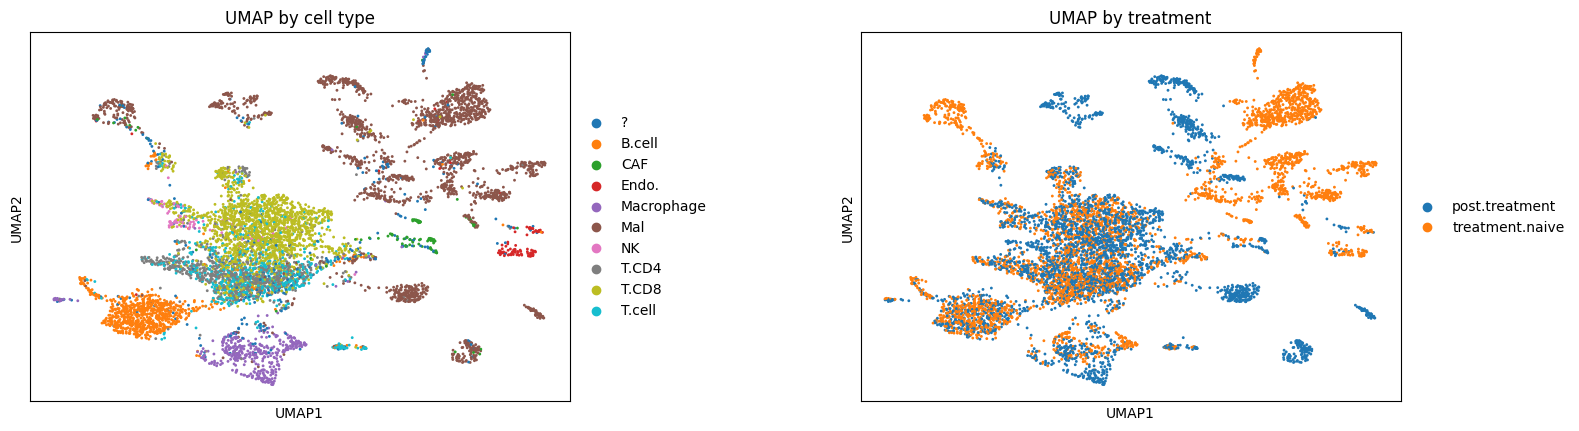

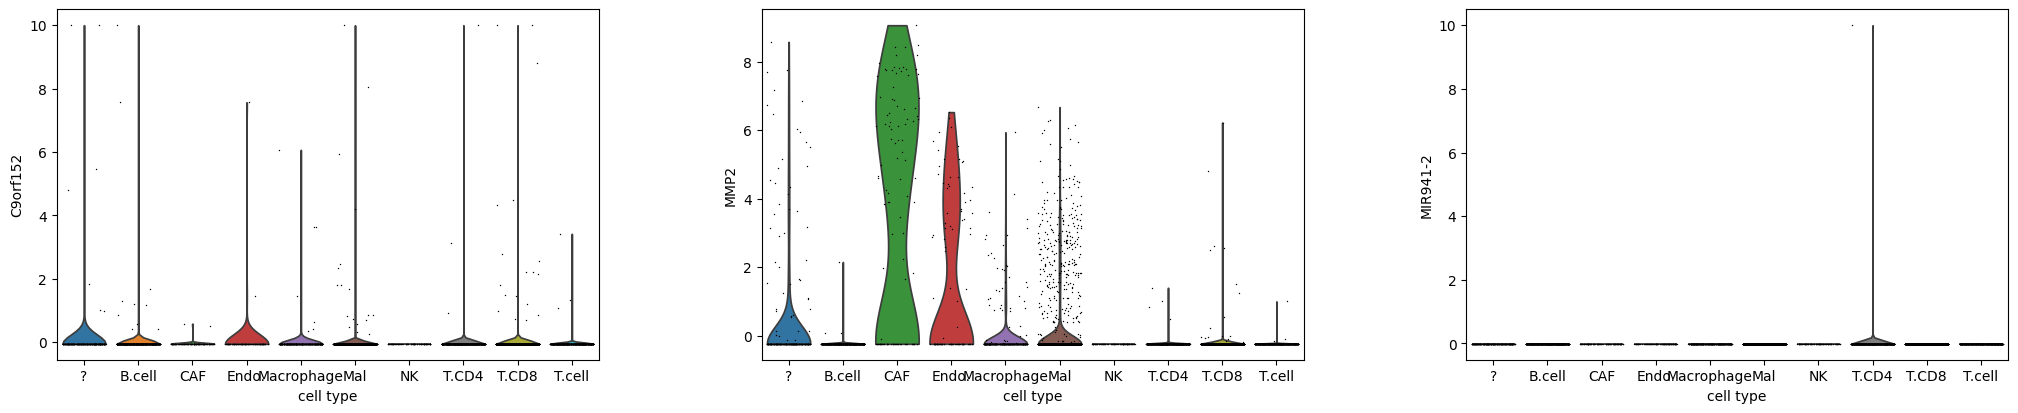

In [11]:
# Ensure float type for processing
adata_115978.X = adata_115978.X.astype(float)

# Detect highly variable genes (HVG)
sc.pp.highly_variable_genes(adata_115978, n_top_genes=2000, subset=True, flavor='seurat')

# Scale
sc.pp.scale(adata_115978, max_value=10)

# Run PCA
sc.tl.pca(adata_115978)

# Build neighborhood graph for UMAP
sc.pp.neighbors(adata_115978)

# Run UMAP
sc.tl.umap(adata_115978)

# Plot PCA with titles
sc.pl.pca(
    adata_115978,
    color=['cell_type', 'treatment'],
    wspace=0.4,
    title=['PCA by cell type', 'PCA by treatment']
)

# Plot UMAP with titles
sc.pl.umap(
    adata_115978,
    color=['cell_type', 'treatment'],
    wspace=0.4,
    title=['UMAP by cell type', 'UMAP by treatment']
)

# Violin plots for top genes
top_genes = adata_115978.var_names[:3]
sc.pl.violin(adata_115978, keys=top_genes, groupby='cell_type', jitter=0.4)




The code performs a tumor-vs-immune differential expression screen on the Jerby-Arnon GSE115978 dataset. It clones the AnnData, maps cell_type == 'Mal' to a "tumor" group and everything else to "immune" (no unresolved class here), yielding 5,168 immune and 2,018 tumor cells. To reduce noise/memory, it restricts to the top 5,000 HVGs (Seurat flavor), converts the matrix to dense, and adds a small epsilon to curb log2(0) issues. DE is run with Scanpy’s t-test_overestim_var and pts=True, then results are assembled into a tidy table and the top hits per group are reported by largest log2FC. In this run, notable tumor-up genes include TMEM244 (log2FC≈7.97, q≈7.3e-4), IL2 (≈5.27, q≈7.2e-4), ESM1 (≈5.44, q≈1.7e-3), XCR1 (≈6.13, q≈3.1e-3), SFN (≈7.80, q≈0.029), with others showing big effects but weaker FDRs (e.g., HIST1H2BB q≈0.059, LOC440335 q≈0.193). Prominent immune-up genes include KRTAP21-1 (≈9.05, q≈0.019), FABP1 (≈4.46, q≈0.016), LCE5A (≈4.05, q≈0.017), CRNN (≈3.83, q≈0.021), and SNORD116-18 (≈4.59, q≈0.030), while several others are borderline (e.g., TAS2R4 q≈0.067). Scanpy emits RuntimeWarning: invalid value encountered in log2, indicating some near-zero expression contrasts despite the epsilon. Overall, the pass recovers a mix of significant and borderline signals, with several surprisingly “tumor-up” immune-associated markers (e.g., XCR1, IL2) that warrant follow-up checks on grouping, detection fractions, or sparsity effects.

In [12]:
# Keep tumor vs immune; drop unresolved
adata_de = adata_115978.copy()
ct = adata_de.obs['cell_type'].astype(str)
grp = pd.Series(np.where(ct.eq('Mal'), 'tumor', 'immune'),
                index=adata_de.obs_names, dtype='string')
adata_de.obs['cell_group'] = pd.Categorical(grp, categories=['tumor','immune'])
print("Group sizes:", adata_de.obs['cell_group'].value_counts().to_dict())

# Focus on HVGs to cut noise (and RAM) before densifying
# Use flavor="seurat" for consistency with GSE72056
sc.pp.highly_variable_genes(adata_de, n_top_genes=5000, flavor="seurat")
adata_de = adata_de[:, adata_de.var['highly_variable']].copy()

# Densify + epsilon so zeros don’t trigger log2 warnings
# Convert sparse matrix to dense if needed, then add small epsilon
if sp.issparse(adata_de.X):
    adata_de.X = adata_de.X.toarray()
adata_de.X = adata_de.X.astype(np.float32) + 1e-6

# Differential expression
# Use variance-overestimated t-test for stability
sc.tl.rank_genes_groups(
    adata_de,
    groupby='cell_group',
    method='t-test_overestim_var',
    pts=True,
    tie_correct=True
)

# Differential expression DataFrame
try:
    df = sc.get.rank_genes_groups_df(adata_de, group=None)  # Scanpy ≥1.9
    df = df.rename(columns={
        'names':'gene', 'logfoldchanges':'log2fc',
        'pvals_adj':'pval_adj', 'scores':'score', 'group':'group'
    })
    de_df_115 = df[['gene','log2fc','pval_adj','score','group']].copy()
except Exception:
    res = adata_de.uns['rank_genes_groups']; groups = res['names'].dtype.names
    frames = []
    for g in groups:
        frames.append(pd.DataFrame({
            'gene': res['names'][g],
            'log2fc': res['logfoldchanges'][g],
            'pval_adj': res['pvals_adj'][g],
            'score': res['scores'][g],
            'group': g
        }))
    de_df_115 = (pd.concat(frames, ignore_index=True)
                   .replace([np.inf,-np.inf], np.nan)
                   .dropna(subset=['log2fc','pval_adj']))

# Print top markers
top_tumor  = de_df_115.query("group=='tumor'").nlargest(10, 'log2fc')[['gene','log2fc','pval_adj']]
top_immune = de_df_115.query("group=='immune'").nlargest(10, 'log2fc')[['gene','log2fc','pval_adj']]

print("\nTop tumor markers:")
print(top_tumor.to_string(index=True))
print("\nTop immune markers:")
print(top_immune.to_string(index=True))

Group sizes: {'immune': 5168, 'tumor': 2018}

Top tumor markers:
           gene    log2fc  pval_adj
1607  HIST1H2BB  8.245166  0.059231
1729    TMEM244  7.974294  0.000730
1634        SFN  7.796751  0.029043
1517  LOC440335  7.245311  0.192536
1698       XCR1  6.134097  0.003086
1540    SNORD28  5.475289  0.163291
1712       ESM1  5.441571  0.001727
1591    SNORD26  5.382276  0.086000
1612      TACR1  5.280501  0.053402
1730        IL2  5.274881  0.000716

Top immune markers:
             gene    log2fc  pval_adj
3235    KRTAP21-1  9.048631  0.019331
3185       TAS2R4  6.797203  0.066889
3163        NPTX1  5.626343  0.108292
3215  SNORD116-18  4.594625  0.029584
3239        FABP1  4.457960  0.015888
3055      DCSTAMP  4.185767  0.360852
3237        LCE5A  4.054417  0.017027
3231         CRNN  3.825743  0.020793
3187       OR51B4  3.706457  0.065621
3158         ZFP2  3.670310  0.117443


c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


The block builds a volcano plot for the GSE115978 tumor-vs-immune DE results. It copies the DE table, computes –log10(FDR) (safely clipping tiny p-values to avoid infinities), and applies standard cutoffs |log2FC| ≥ 1 and FDR < 0.05. Points are colored blue for significant tumor-enriched genes (positive log2FC), red for significant immune-enriched genes (negative log2FC), and light gray otherwise. Dashed vertical lines mark the fold-change thresholds and the horizontal line marks the FDR threshold. The code then labels the 10 most significant genes on each side.

The resulting plot shows a left-skewed cloud of blue points (many immune-enriched genes passing both thresholds with high –log10(FDR)) and a smaller right-hand cluster of red points (fewer tumor-enriched genes meeting the same criteria). Several of the most significant features on each side are annotated on the figure. If the DE table combines per-group statistics, some genes can appear on both sides (with opposite signs), which explains duplicated labels you may notice. Overall, the visualization highlights that in this dataset the immune-biased signals are more numerous and statistically stronger than tumor-biased signals, while still surfacing a distinct set of tumor-enriched candidates for follow-up.

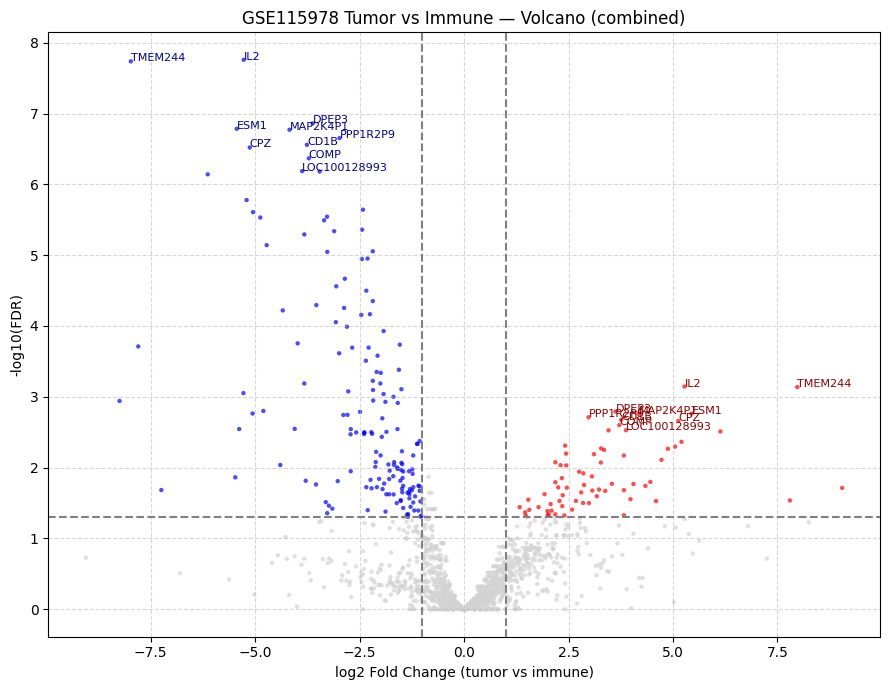

In [13]:
# Volcano plot
dfv = de_df_115.copy()
dfv['neg_log10_pval'] = -np.log10(dfv['pval_adj'].clip(lower=1e-300))
fc_thr, q_thr = 1.0, 0.05
dfv['color'] = np.where((dfv['pval_adj'] < q_thr) & (dfv['log2fc'] >=  fc_thr), 'red',
                 np.where((dfv['pval_adj'] < q_thr) & (dfv['log2fc'] <= -fc_thr), 'blue', 'lightgrey'))

# Plot the volcano plot
plt.figure(figsize=(9,7))
plt.scatter(dfv['log2fc'], dfv['neg_log10_pval'], c=dfv['color'], s=10, alpha=0.7, edgecolors='none')
plt.axvline( fc_thr, ls='--', c='grey'); plt.axvline(-fc_thr, ls='--', c='grey')
plt.axhline(-np.log10(q_thr), ls='--', c='grey')

# Label top significant genes from each side
for _, r in dfv[dfv['color']=='red' ].nsmallest(10, 'pval_adj').iterrows():
    plt.text(r['log2fc'], r['neg_log10_pval'], r['gene'], fontsize=8, color='darkred')
for _, r in dfv[dfv['color']=='blue'].nsmallest(10, 'pval_adj').iterrows():
    plt.text(r['log2fc'], r['neg_log10_pval'], r['gene'], fontsize=8, color='darkblue')

# Add labels and title
plt.title("GSE115978 Tumor vs Immune — Volcano (combined)")
plt.xlabel("log2 Fold Change (tumor vs immune)")
plt.ylabel("-log10(FDR)")
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

This block integrates the GSE72056 and GSE115978 scRNA-seq datasets by removing all-zero genes within each set, keeping only the intersecting genes, and concatenating them with a batch label. It adds a small epsilon, normalizes each cell to 1e4 counts, applies log1p, replaces NaNs with 0, and drops any genes that remain zero-sum after normalization. Next, it selects 2,000 highly variable genes using Scanpy’s batch-aware HVG routine, scales the data, and runs PCA; these pre-integration PCA panels show a noticeable batch signal with some overlap. For integration, it applies BBKNN (Batch Balanced k-NN) to construct a neighbor graph where each cell draws a balanced set of neighbors from every batch, crucially adjusting the graph, not the expression matrix, then computes UMAP on that graph. The resulting UMAP shows good cross-study mixing by batch and biologically coherent structure when colored by cell type and malignant status, with some unresolved/NA cells interspersed.


C:\Users\josha\AppData\Local\Temp\ipykernel_21016\542014016.py:11: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_72056.concatenate(
c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\legacy_api_wrap\__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\scanpy\preprocessing\_simple.py:392: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:705: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


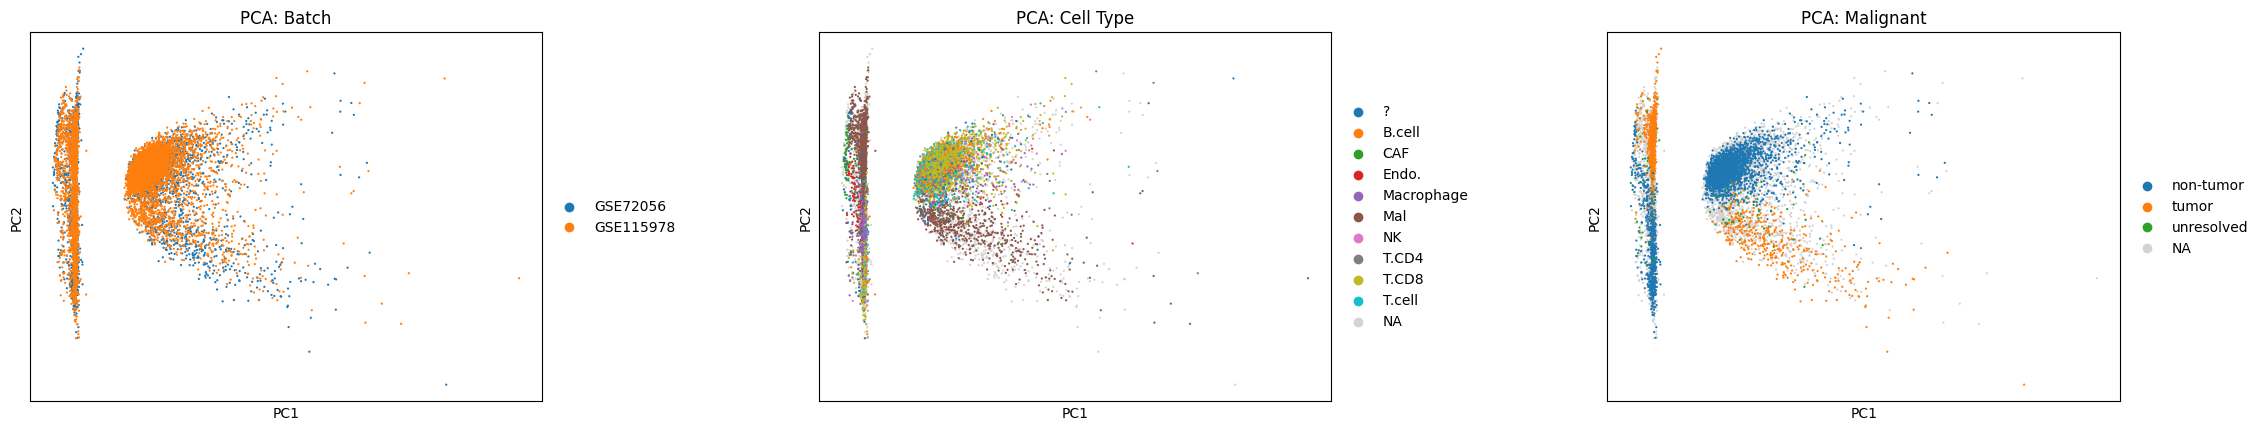

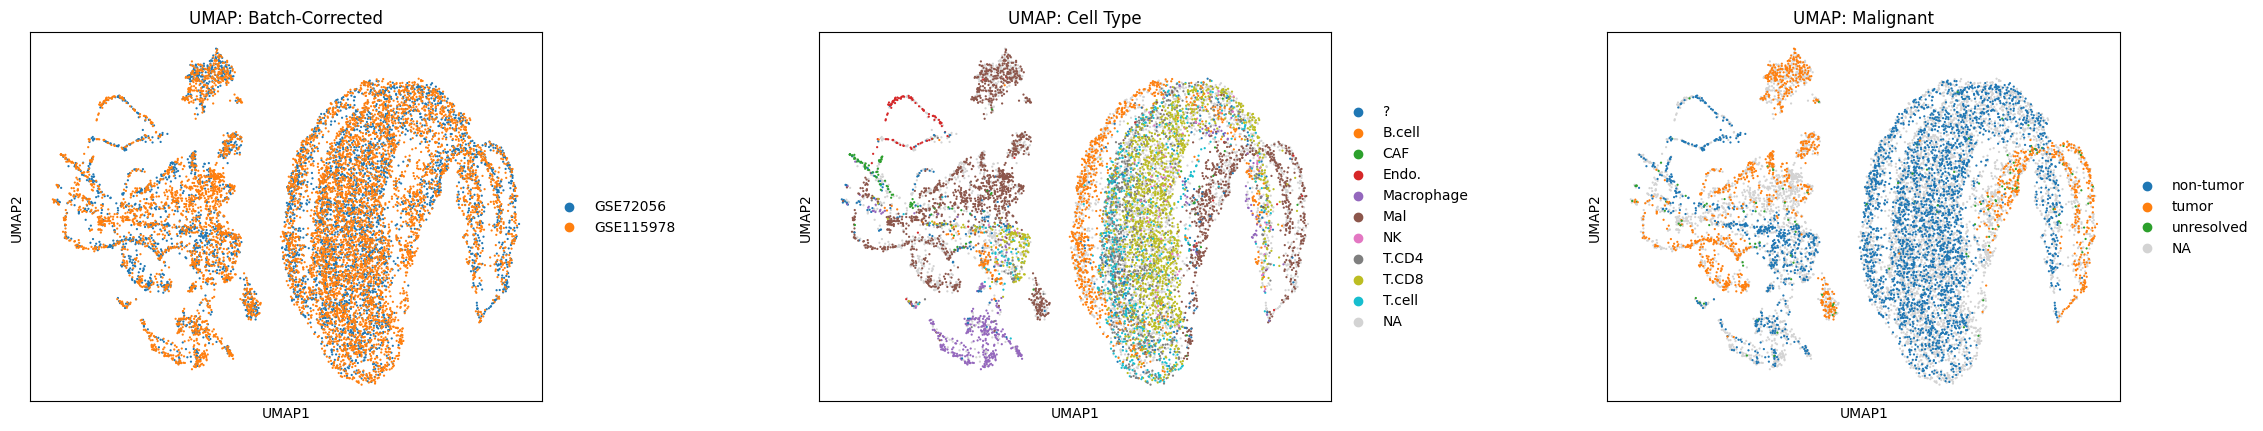

In [14]:
# Pre-filter genes with all-zero counts in each dataset
adata_72056 = adata_72056[:, (adata_72056.X.sum(axis=0) != 0).ravel()]
adata_115978 = adata_115978[:, (adata_115978.X.sum(axis=0) != 0).ravel()]

# Intersect genes
common_genes = adata_72056.var_names.intersection(adata_115978.var_names)
adata_72056 = adata_72056[:, common_genes].copy()
adata_115978 = adata_115978[:, common_genes].copy()

# Merge datasets
adata_combined = adata_72056.concatenate(
    adata_115978,
    batch_key="batch",
    batch_categories=["GSE72056", "GSE115978"]
)

# Normalize, log, clean
adata_combined.X = adata_combined.X + 1e-6  # Avoid log(0)
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)
adata_combined.X = np.nan_to_num(adata_combined.X, nan=0.0)
adata_combined = adata_combined[:, adata_combined.X.sum(axis=0) > 0]

# HVG selection
sc.pp.highly_variable_genes(adata_combined, batch_key='batch', n_top_genes=2000, subset=True)

# Scale, PCA
sc.pp.scale(adata_combined, max_value=10)
sc.tl.pca(adata_combined, svd_solver='arpack')

# Batch correction with BBKNN
bbknn.bbknn(adata_combined, batch_key='batch')

# UMAP
sc.tl.umap(adata_combined)

# Visualize
sc.pl.pca(adata_combined, color=['batch', 'cell_type', 'malignant'], wspace=0.4,
          title=['PCA: Batch', 'PCA: Cell Type', 'PCA: Malignant'])
sc.pl.umap(adata_combined, color=['batch', 'cell_type', 'malignant'], wspace=0.4,
           title=['UMAP: Batch-Corrected', 'UMAP: Cell Type', 'UMAP: Malignant'])


This block performs a focused tumor-vs-immune DE analysis on the integrated dataset. It subsets cells to malignant (“Mal”) and major immune types, labels them as two groups (tumor, immune), and runs Scanpy’s Wilcoxon test via rank_genes_groups to obtain per-gene scores and FDRs; the “immune vs. rest / tumor vs. rest” ranking figure is drawn from this same key. The volcano plot is built from the tumor contrast only, with thresholds |score| > 1.5 and FDR < 0.05; consequently, negative scores in this plot indicate genes higher in the immune group, so immune-enriched genes appear on the left, tumor-enriched on the right. Most points lie above the FDR line (broad significance consistent with large N), and all significant points are colored the same (no separate color for direction). Labeled top hits match the contrasts (tumor-up: SPARC, C7orf55, GEMIN8, POU5F1, AKIP1, SLC35B2, RPL7, UGDH-AS1, PLTP, SERF1B; immune-up: FPR1, LILRB4, MNDA, VSIG4, FBP1, TREM2, LILRA3, FCN1, LILRA2, FOLR2). The consolidated violin grids corroborate these patterns, showing higher expression in the corresponding group.

c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


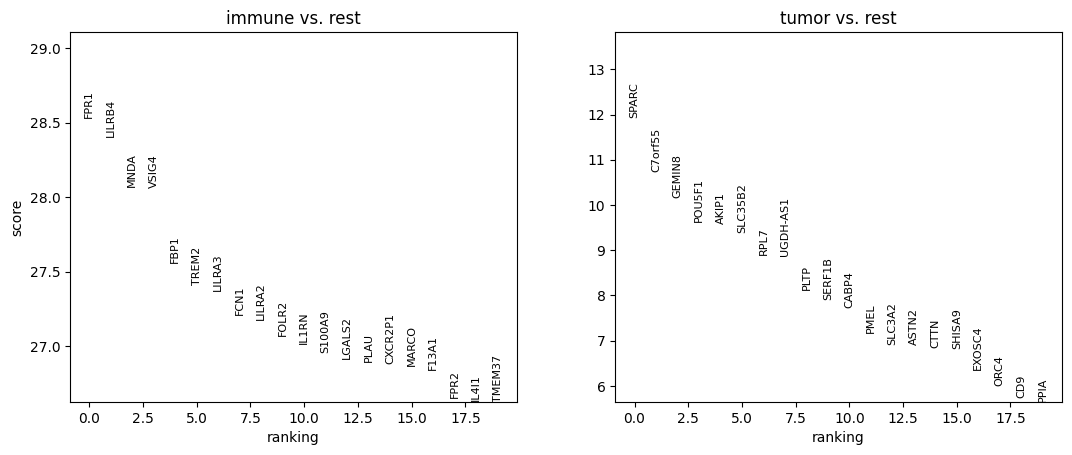

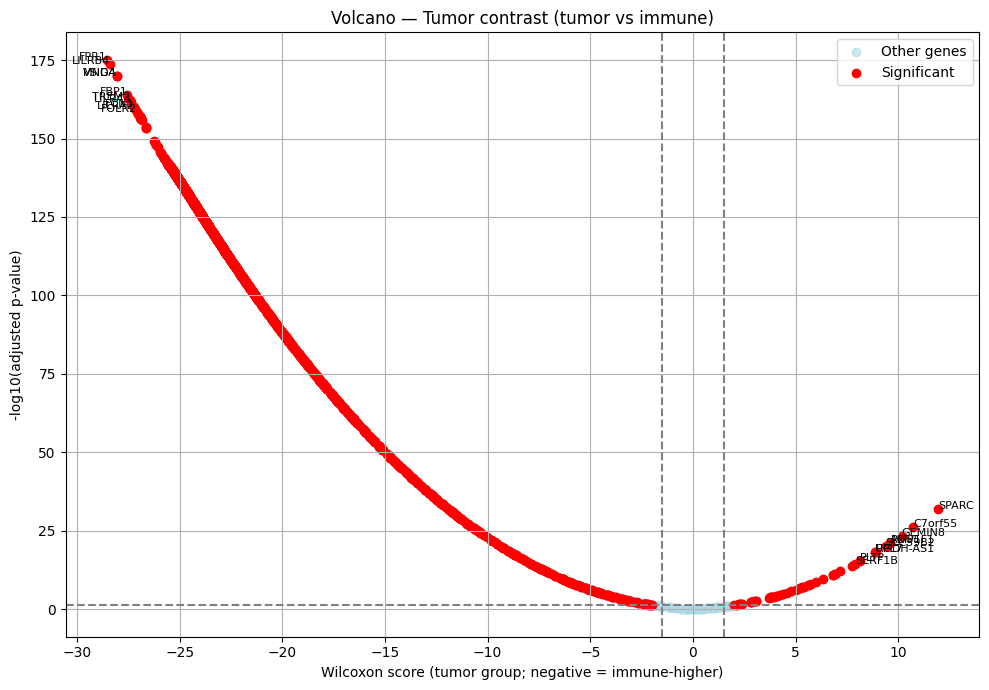

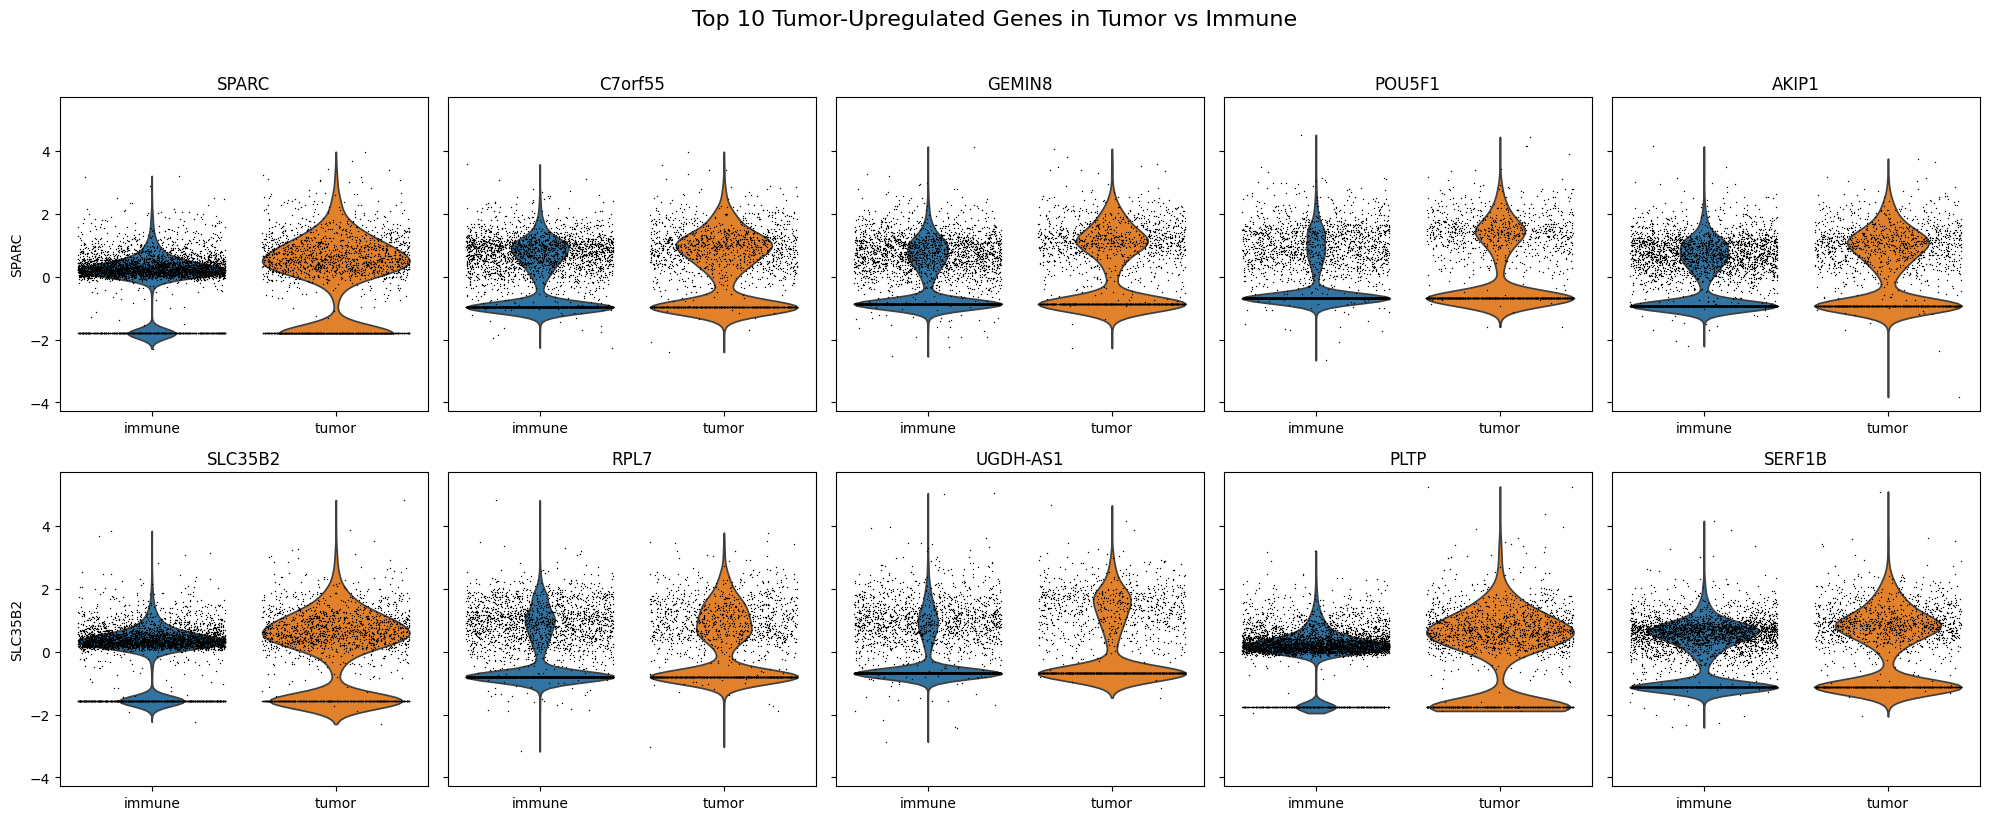

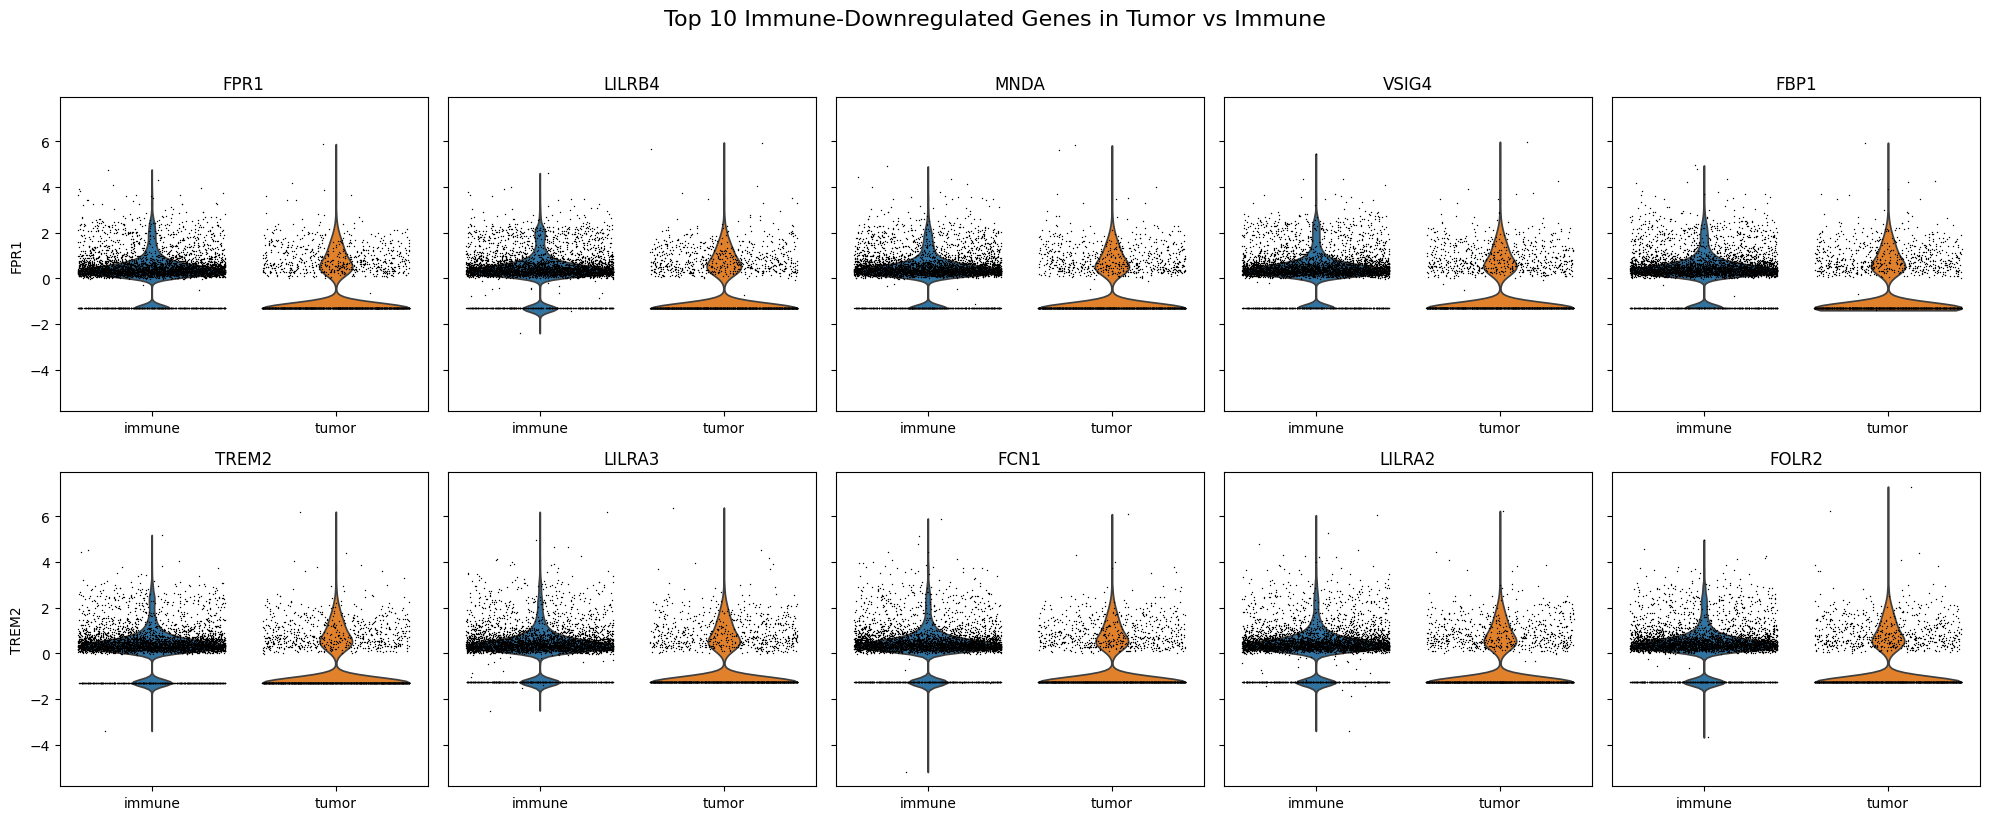

In [15]:
# Define tumor vs immune cell types
tumor_mask = adata_combined.obs['cell_type'] == 'Mal'
immune_mask = adata_combined.obs['cell_type'].isin(['T.cell', 'T.CD4', 'T.CD8', 'B.cell', 'Macrophage', 'NK'])

# Create subset
adata_de = adata_combined[tumor_mask | immune_mask].copy()

# Assign group labels
adata_de.obs['group'] = ['tumor' if ct == 'Mal' else 'immune' for ct in adata_de.obs['cell_type']]

# Differential expression
sc.tl.rank_genes_groups(adata_de, groupby='group', method='wilcoxon', key_added='rank_tumor_immune')

# Summary barplot
sc.pl.rank_genes_groups(adata_de, key='rank_tumor_immune', n_genes=20, sharey=False, title='Top DE Genes: Tumor vs Immune')

# Volcano plot with thresholds and labeled genes
de_results = adata_de.uns['rank_tumor_immune']
genes = de_results['names']['tumor']
scores = de_results['scores']['tumor']
pvals_adj = de_results['pvals_adj']['tumor']

# Build DataFrame
df = pd.DataFrame({
    'gene': genes,
    'score': scores,
    'pval_adj': pvals_adj,
    'log10_pval': -np.log10(pvals_adj)
})

# Thresholds
score_thresh = 1.5
pval_thresh = 0.05
df['significant'] = (np.abs(df['score']) > score_thresh) & (df['pval_adj'] < pval_thresh)

# Top 10 tumor and immune upregulated genes
df_up = df[df['score'] > score_thresh].nsmallest(10, 'pval_adj')
df_down = df[df['score'] < -score_thresh].nsmallest(10, 'pval_adj')

# Volcano plot
plt.figure(figsize=(10, 7))
plt.scatter(df['score'], df['log10_pval'], alpha=0.6, label='Other genes', color='lightblue')
plt.scatter(df[df['significant']]['score'], df[df['significant']]['log10_pval'], color='red', label='Significant')

# Annotate plot with top genes
for _, row in pd.concat([df_up, df_down]).iterrows():
    plt.text(row['score'], row['log10_pval'], row['gene'], fontsize=8,
             ha='right' if row['score'] < 0 else 'left')

plt.axvline(x=score_thresh, color='gray', linestyle='--')
plt.axvline(x=-score_thresh, color='gray', linestyle='--')
plt.axhline(y=-np.log10(pval_thresh), color='gray', linestyle='--')
plt.xlabel("Wilcoxon score (tumor group; negative = immune-higher)")
plt.ylabel('-log10(adjusted p-value)')
plt.title("Volcano — Tumor contrast (tumor vs immune)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Consolidated violin plots for tumor-upregulated genes
top_genes_tumor = df_up['gene'].tolist()
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)

for i, gene in enumerate(top_genes_tumor):
    row, col = divmod(i, 5)
    sc.pl.violin(
        adata_de,
        keys=gene,
        groupby='group',
        jitter=0.4,
        rotation=0,
        ax=axes[row, col],
        show=False
    )
    axes[row, col].set_title(gene)

plt.suptitle("Top 10 Tumor-Upregulated Genes in Tumor vs Immune", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Consolidated violin plots for immune-upregulated genes
top_genes_immune = df_down['gene'].tolist()
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)

for i, gene in enumerate(top_genes_immune):
    row, col = divmod(i, 5)
    sc.pl.violin(
        adata_de,
        keys=gene,
        groupby='group',
        jitter=0.4,
        rotation=0,
        ax=axes[row, col],
        show=False
    )
    axes[row, col].set_title(gene)

plt.suptitle("Top 10 Immune-Downregulated Genes in Tumor vs Immune", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()




This code block assigns a binary classification label to each cell in the adata_115978 dataset based on its cell_type annotation. Specifically, any cell labeled as 'Mal' (malignant) is categorized as 'tumor', while all other cell types are assigned the label 'non-tumor'. This preprocessing step simplifies downstream analyses. such as model training or differential expression, by consolidating heterogeneous cell-type annotations into two biologically relevant groups that directly reflect malignant versus non-malignant status.


In [16]:
# Assign 'tumor' to 'Mal', and 'non-tumor' to all other cell types
adata_115978.obs['malignant'] = adata_115978.obs['cell_type'].map(
    lambda x: 'tumor' if x == 'Mal' else 'non-tumor'
)


This code block performs batch-aware highly variable gene (HVG) selection on the integrated adata_combined object, identifying the top 2,000 HVGs while accounting for batch effects using the batch_key="batch" parameter. It stores the HVG mask, then subsets variables in each dataset (adata_72056, adata_115978, and adata_combined) to retain only these HVGs and sets their highly_variable flag to True. Finally, it extracts the HVG names from the combined dataset and saves them to hvg_gene_list.txt for downstream use, such as mapping input features in a Flask-based prediction application.


In [17]:
# Batch-aware HVG selection on combined data
sc.pp.highly_variable_genes(
    adata_combined,
    batch_key="batch",
    n_top_genes=2000,
    subset=False
)

# Get HVG mask
hvg_mask = adata_combined.var['highly_variable'].copy()

# Subset and assign HVG column back to each dataset
for ad in [adata_72056, adata_115978, adata_combined]:
    ad._inplace_subset_var(hvg_mask)
    ad.var['highly_variable'] = True

# Save HVG gene names for Flask input mapping
hvg_names = adata_combined[:, adata_combined.var['highly_variable']].var_names.to_list()
with open("hvg_gene_list.txt", "w") as f:
    f.write("\n".join(hvg_names))


c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\josha\EU MSDS\DTSC 691_Applied Data Science\Project\.venv\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:693: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  df = _highly_variable_genes_batched(


This code block trains a denoising autoencoder (Dropout 0.2, Dense 512, 128, 30-D bottleneck, 128, 512, linear output; Adam+MSE, 50 epochs, batch 128) on HVG-filtered expression from GSE72056, encoded both train and GSE115978 test cells into the 30-D latent space, and fit a RandomForest (100 trees, random_state=42) on the latent features. On the held-out GSE115978 set (n=7,186), performance was strong: accuracy 0.96, AUC-ROC 0.98, with classwise precision/recall/F1 of 0.96/0.98/0.97 for non-tumor (n=5,168) and 0.94/0.90/0.92 for tumor (n=2,018). The confusion matrix shows most errors are tumor→non-tumor (FN=193), consistent with the ROC curve’s high separability. 

In [18]:
# Model pipeline: Denoising Autoencoder + Random Forest

# Build a denoising autoencoder
def build_denoising_autoencoder(input_dim, latent_dim=30, dropout_rate=0.2):
    input_layer = Input(shape=(input_dim,))
    noisy_input = Dropout(dropout_rate)(input_layer)
    
    # Encoder
    encoded = Dense(512, activation='relu')(noisy_input)
    encoded = Dense(128, activation='relu')(encoded)
    bottleneck = Dense(latent_dim, activation='linear', name='latent_space')(encoded)
    
    # Decoder
    decoded = Dense(128, activation='relu')(bottleneck)
    decoded = Dense(512, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    encoder = Model(inputs=input_layer, outputs=bottleneck)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Prepare features and labels from AnnData
def build_denoising_autoencoder(input_dim, latent_dim=30, dropout_rate=0.2):
    input_layer = Input(shape=(input_dim,))
    noisy_input = Dropout(dropout_rate)(input_layer)
    # Encoder
    x = Dense(512, activation='relu')(noisy_input)
    x = Dense(128, activation='relu')(x)
    bottleneck = Dense(latent_dim, activation='linear', name='latent_space')(x)
    # Decoder
    x = Dense(128, activation='relu')(bottleneck)
    x = Dense(512, activation='relu')(x)
    output_layer = Dense(input_dim, activation='linear')(x)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    encoder = Model(inputs=input_layer, outputs=bottleneck)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# Prepare dataset for modeling
def prepare_dataset(adata, hvg_key="highly_variable", label_key="malignant"):
    # Ensure tumor/non-tumor label exists (maps 'Mal' -> tumor; everything else -> non-tumor)
    if label_key not in adata.obs:
        ct = adata.obs.get("cell_type", None)
        if ct is None:
            raise KeyError("cell_type column not found to derive malignant labels.")
        ct = ct.astype("string")
        adata = adata.copy()
        adata.obs[label_key] = np.where(ct.eq("Mal"), "tumor", "non-tumor")

    # Keep only rows with the two classes
    ad = adata[adata.obs[label_key].isin(["tumor", "non-tumor"])].copy()

    # Use HVG mask if available
    if hvg_key in ad.var and ad.var[hvg_key].any():
        gene_mask = ad.var[hvg_key].values
    else:
        gene_mask = np.ones(ad.n_vars, dtype=bool)

    # Slice to features and convert to dense
    X_mat = ad[:, gene_mask].X
    X = X_mat.A if sp.issparse(X_mat) else np.asarray(X_mat, dtype=np.float32)

    # Encode labels (alphabetical -> non-tumor=0, tumor=1)
    y = LabelEncoder().fit_transform(ad.obs[label_key])

    return X, y, ad

# Train and evaluate the model
def train_and_evaluate_autoencoded(
    train_adata, test_adata, phase_label, latent_dim=30,
    verbose=False, plot_roc=True, ax=None
):
    X_train_raw, y_train, _ = prepare_dataset(train_adata)
    X_test_raw,  y_test,  _ = prepare_dataset(test_adata)

    # Denoising Autoencoder
    autoencoder, encoder = build_denoising_autoencoder(X_train_raw.shape[1], latent_dim=latent_dim)
    autoencoder.fit(X_train_raw, X_train_raw, epochs=50, batch_size=128, shuffle=True, verbose=0)
    X_train = encoder.predict(X_train_raw, verbose=0)
    X_test  = encoder.predict(X_test_raw,  verbose=0)

    # Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred  = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Metrics
    report_str = classification_report(y_test, y_pred)
    cm         = confusion_matrix(y_test, y_pred)
    auc        = float(roc_auc_score(y_test, y_proba))
    metrics    = {"report": report_str, "confusion_matrix": cm, "roc_auc": auc}

    if verbose:
        print(f"\nClassification Report using DAE: {phase_label}")
        print(report_str)
        print("Confusion Matrix:\n", cm)
        print("AUC-ROC Score:", auc)

    # ROC curve
    disp = None
    if plot_roc:
        disp = RocCurveDisplay.from_predictions(y_test, y_proba, name="Classifier", ax=ax)
        if ax is None:
            plt.title(f"ROC Curve - {phase_label}")
            plt.show()
        else:
            ax.set_title(f"ROC Curve - {phase_label}")

    return clf, encoder, metrics, disp


Classification Report using DAE: 72056 → 115978
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5168
           1       0.94      0.90      0.92      2018

    accuracy                           0.96      7186
   macro avg       0.95      0.94      0.95      7186
weighted avg       0.96      0.96      0.96      7186

Confusion Matrix:
 [[5048  120]
 [ 194 1824]]
AUC-ROC Score: 0.9866556544505029


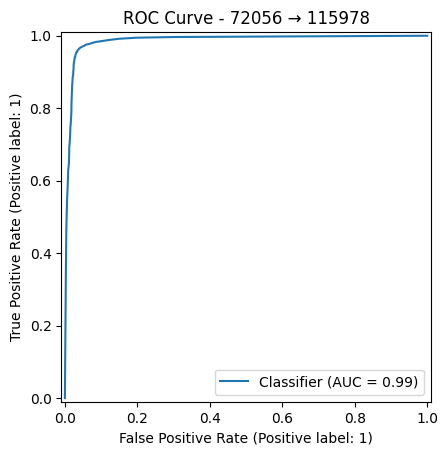

In [19]:
# Output Model Performance Metrics

clf, enc, metrics, _ = train_and_evaluate_autoencoded(
    adata_72056, adata_115978, "72056 → 115978", verbose=True, plot_roc=True
)


This block evaluates the DAE→Random Forest pipeline with HVG inputs and a 30-D latent space in three settings: (1) train on GSE72056 → test on GSE115978, (2) train on GSE115978 → test on GSE72056, and (3) combined train/validate. In the cross-dataset runs the DAE is fit only on the source dataset, its encoder transforms both source and target, and a 100-tree RF is trained on the source latent features. Results: 72056→115978 achieves accuracy 0.96, macro-F1 0.95, AUC-ROC 0.9873, with confusion matrix [[5044, 124], [156, 1862]] (most errors are tumor→non-tumor). 115978→72056 achieves accuracy 0.98, macro-F1 0.98, AUC-ROC 0.9965, with confusion matrix [[3237, 19], [53, 1204]]. For the combined evaluation, a single DAE is trained on the 80% train split only (no leakage), the RF reaches accuracy 0.99 and AUC-ROC 0.9997 on the 20% validation split, with confusion matrix [[651, 0], [11, 241]]. ROC curves for all three configurations show very high separability, confirming that the DAE latent features transfer robustly across studies.


Classification Report using DAE: Train on GSE72056 → Test on GSE115978 (DAE)
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5168
           1       0.94      0.91      0.92      2018

    accuracy                           0.96      7186
   macro avg       0.95      0.94      0.95      7186
weighted avg       0.96      0.96      0.96      7186

Confusion Matrix:
 [[5050  118]
 [ 185 1833]]
AUC-ROC Score: 0.9882876384213901


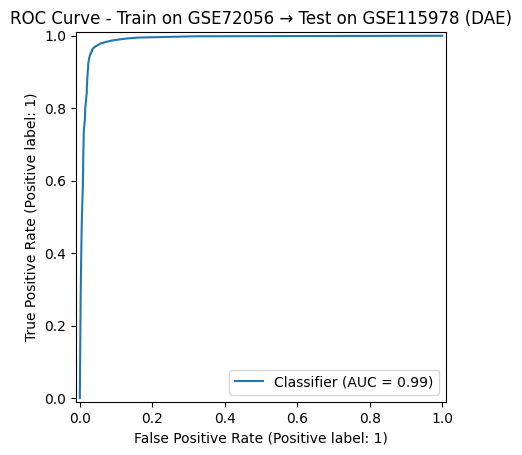


Classification Report using DAE: Train on GSE115978 → Test on GSE72056 (DAE)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3256
           1       0.99      0.95      0.97      1257

    accuracy                           0.98      4513
   macro avg       0.98      0.97      0.98      4513
weighted avg       0.98      0.98      0.98      4513

Confusion Matrix:
 [[3240   16]
 [  59 1198]]
AUC-ROC Score: 0.9961448077498197


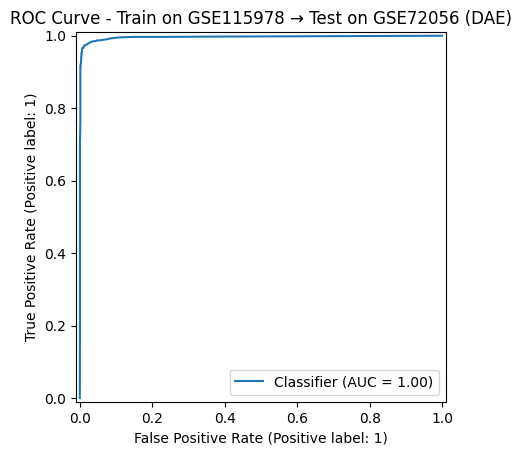


Classification Report: Combined Dataset with DAE Features (train 80% → validate 20%)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       651
           1       1.00      0.96      0.98       252

    accuracy                           0.99       903
   macro avg       0.99      0.98      0.99       903
weighted avg       0.99      0.99      0.99       903

Confusion Matrix:
 [[651   0]
 [  9 243]]
AUC-ROC: 0.9992685246141468


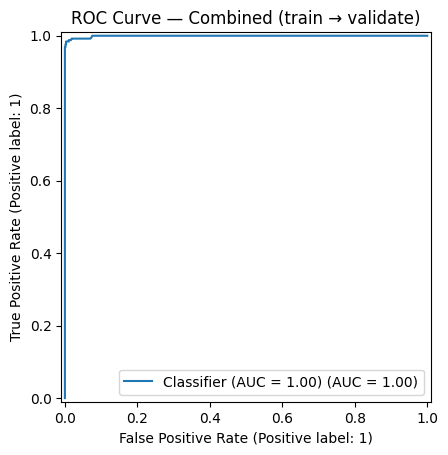

In [20]:
# Train on GSE72056 → Test on GSE115978 (DAE)
# Train on GSE115978 → Test on GSE72056 (DAE)
clf_72056_dae, enc_72056, m_72_115, _ = train_and_evaluate_autoencoded(
    adata_72056, adata_115978, "Train on GSE72056 → Test on GSE115978 (DAE)", verbose=True
)
clf_115978_dae, enc_115978, m_115_72, _ = train_and_evaluate_autoencoded(
    adata_115978, adata_72056, "Train on GSE115978 → Test on GSE72056 (DAE)", verbose=True
)

# Train on combined dataset with 80/20 split (DAE)
X_all, y_all, _ = prepare_dataset(adata_combined)

# Stratified split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y_all, test_size=0.20, stratify=y_all, random_state=42
)

# Train DAE + RF on combined training set
ae_c, enc_c = build_denoising_autoencoder(input_dim=X_tr.shape[1], latent_dim=30)
ae_c.fit(X_tr, X_tr, epochs=50, batch_size=128, shuffle=True, verbose=0)

# Transform training and validation sets
Z_tr  = enc_c.predict(X_tr,  verbose=0)
Z_val = enc_c.predict(X_val, verbose=0)


# Train Random Forest on DAE features
clf_combined_dae = RandomForestClassifier(n_estimators=100, random_state=42)
clf_combined_dae.fit(Z_tr, y_tr)

# Evaluate on validation set
y_pred = clf_combined_dae.predict(Z_val)
y_prob = clf_combined_dae.predict_proba(Z_val)[:, 1]

print("\nClassification Report: Combined Dataset with DAE Features (train 80% → validate 20%)")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
auc = roc_auc_score(y_val, y_prob)
print("AUC-ROC:", float(auc))

RocCurveDisplay.from_predictions(y_val, y_prob, name=f"Classifier (AUC = {auc:.2f})")
plt.title("ROC Curve — Combined (train → validate)")
plt.show()


This code block saves the final trained artifacts from the combined dataset pipeline for later reuse.

* The fully processed combined AnnData object is saved as adata_combined.h5ad for downstream analysis or reloading without repeating preprocessing.
* The trained DAE encoder (encoder_comb) is serialized to dae_encoder_model.pkl using joblib, preserving the feature extraction step.
* The trained Random Forest classifier (clf_combined_dae) is saved as clf_combined_dae.pkl for making predictions without retraining.
* A commented-out line indicates that top gene mappings could also be exported as top_genes_per_latent.csv if generated.

The output ['clf_combined_dae.pkl'] confirms the classifier file was successfully created and saved.


In [21]:
# Save models and combined AnnData object
adata_combined.write("adata_combined.h5ad")

joblib.dump(enc_c, "dae_encoder_model.pkl")

joblib.dump(clf_combined_dae, "clf_combined_dae.pkl")

['clf_combined_dae.pkl']

In [22]:
# Get inputs/labels from the combined AnnData (HVG-filtered, tumor/non-tumor only)
X_all, y_comb, _ = prepare_dataset(adata_combined)

# Pick the encoder to use for benchmarking:
try:
    encoder_for_benchmark = enc_c
except NameError:
    encoder_for_benchmark = encoder_comb

# Encode all combined cells into latent space
X_latent_comb = encoder_for_benchmark.predict(X_all, verbose=0)

This block benchmarks three classifiers (Random Forest, Logistic Regression, and XGBoost) on the latent feature matrix (X_latent_comb) for tumor vs. non-tumor classification. The data are split into stratified train/test sets, labels are encoded, and each model is trained and evaluated on accuracy, precision, recall, F1, and ROC-AUC. All models achieved near-perfect performance (≈0.99 accuracy, AUC = 1.00), indicating the latent representation is highly discriminative. Logistic Regression was fastest to train (~0.04s), while Random Forest and XGBoost provided similar accuracy with longer fit times. The ROC plot shows all curves tightly hugging the top-left corner, confirming strong separability. Results were saved to benchmark_latent_models.csv.

Accuracy  Precision  Recall    F1  ROC_AUC  Fit_Time_s
Model                                                                     
RandomForest            0.99       1.00    0.96  0.98      1.0        1.79
LogisticRegression      0.99       0.99    0.96  0.98      1.0        0.02
XGBoost                 0.99       1.00    0.97  0.98      1.0        0.59

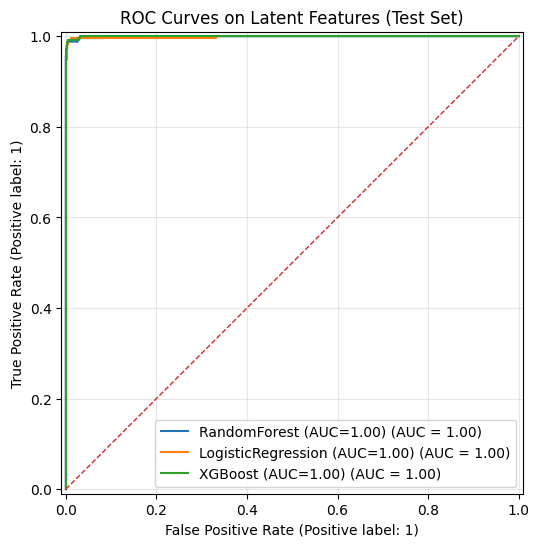

Saved: benchmark_latent_models.csv


In [23]:
# Benchmark multiple models on latent features from combined dataset
from sklearn.linear_model import LogisticRegression
X = np.asarray(X_latent_comb)  # (n_samples, 30)

# labels: prefer y_comb; else infer from adata_combined.obs
try:
    y = np.asarray(y_comb)
except NameError:
    obs = adata_combined.obs
    col = next(c for c in ["cell_group","malignant","group"] if c in obs.columns)
    s = obs[col].astype(str).str.lower()
    y = np.where(
        s.eq("tumor") if col != "malignant" else s.isin(["mal","tumor","true","1","yes"]),
        "tumor", "non-tumor"
    )

# train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# encode labels; ensure 'tumor' == 1
le = LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train); y_test_enc = le.transform(y_test)
if "tumor" in le.classes_ and le.transform(["tumor"])[0] == 0:
    y_train_enc, y_test_enc = 1 - y_train_enc, 1 - y_test_enc

# models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1),
    "LogisticRegression": make_pipeline(StandardScaler(),
                                       LogisticRegression(max_iter=5000, solver="liblinear", random_state=42)),
}
try:
    from xgboost import XGBClassifier
    models["XGBoost"] = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=4,
                                      subsample=0.9, colsample_bytree=0.9, tree_method="hist",
                                      eval_metric="logloss", random_state=42, n_jobs=-1)
except Exception:
    pass

# benchmark
rows, scores = [], {}
for name, mdl in models.items():
    t0 = time.time(); mdl.fit(X_train, y_train_enc); ft = time.time() - t0
    y_pred  = mdl.predict(X_test)
    y_score = mdl.predict_proba(X_test)[:,1] if hasattr(mdl,"predict_proba") else mdl.decision_function(X_test)
    rows.append(dict(
        Model=name,
        Accuracy=accuracy_score(y_test_enc, y_pred),
        Precision=precision_score(y_test_enc, y_pred, zero_division=0),
        Recall=recall_score(y_test_enc, y_pred, zero_division=0),
        F1=f1_score(y_test_enc, y_pred, zero_division=0),
        ROC_AUC=roc_auc_score(y_test_enc, y_score),
        Fit_Time_s=ft
    ))
    scores[name] = y_score

# summary table
df = pd.DataFrame(rows).set_index("Model").astype(float).round(2)
from IPython.display import display; display(df)

# single ROC plot
fig, ax = plt.subplots(figsize=(7,6))
for name, y_score in scores.items():
    RocCurveDisplay.from_predictions(y_test_enc, y_score,
                                     name=f"{name} (AUC={roc_auc_score(y_test_enc, y_score):.2f})", ax=ax)
ax.plot([0,1],[0,1],"--",lw=1); ax.set_title("ROC Curves on Latent Features (Test Set)")
ax.grid(True, alpha=0.3); plt.show()

# Save results
df.to_csv("benchmark_latent_models.csv"); print("Saved: benchmark_latent_models.csv")


This block extends evaluation to precision-recall (PR) analysis and probability calibration. The results table shows: Random Forest (AP = 1.000, Brier = 0.011), Logistic Regression (AP = 0.998, Brier = 0.012), and XGBoost (AP = 0.999, Brier = 0.006). The PR curves demonstrate that all three models sustain very high precision across nearly the entire recall range, consistent with their near-perfect AP scores. The calibration reliability curves indicate that predicted probabilities align reasonably well with observed outcomes, with XGBoost showing the best calibration (lowest Brier score). Together, these metrics confirm that the latent features provide both highly discriminative and well-calibrated predictions.

AP  Brier
RandomForest        0.999  0.010
LogisticRegression  0.998  0.008
XGBoost             0.999  0.007

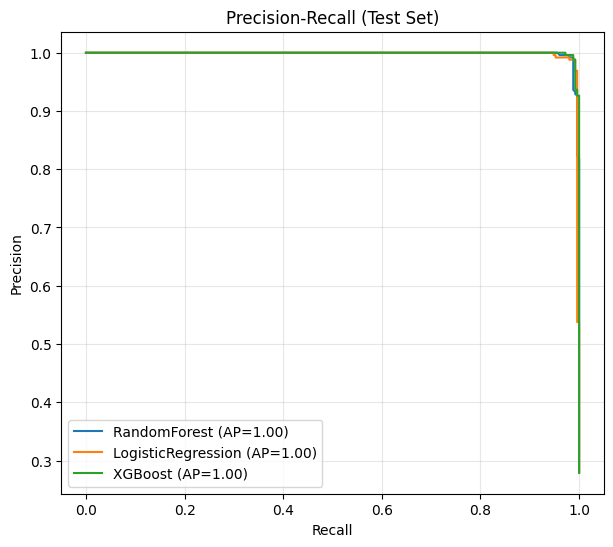

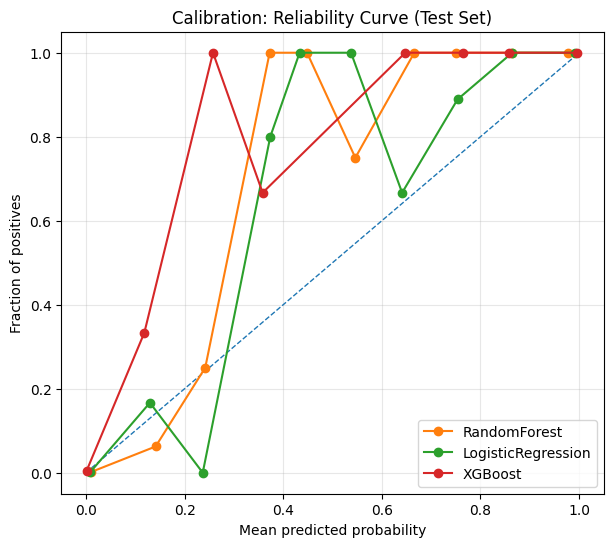

In [24]:
# Probability calibration and PR curves for benchmarked models

# Probability calibration and PR curves
sigmoid = lambda z: 1 / (1 + np.exp(-z))
def proba(model, X):
    if hasattr(model, "predict_proba"):   return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"): return sigmoid(model.decision_function(X))
    return None

# collect probabilities (skip models without a score)
yprob = {name: proba(m, X_test) for name, m in models.items()}
yprob = {k: v for k, v in yprob.items() if v is not None}

# summary table: AP + Brier
summ = pd.DataFrame({
    "AP":    {k: average_precision_score(y_test_enc, v) for k, v in yprob.items()},
    "Brier": {k: brier_score_loss(y_test_enc, v)        for k, v in yprob.items()},
}).round(3)
display(summ)

# PR curve
fig_pr, ax_pr = plt.subplots(figsize=(7, 6))
for name, v in yprob.items():
    p, r, _ = precision_recall_curve(y_test_enc, v)
    ax_pr.plot(r, p, label=f"{name} (AP={summ.loc[name,'AP']:.2f})")
ax_pr.set(title="Precision-Recall (Test Set)", xlabel="Recall", ylabel="Precision")
ax_pr.grid(True, alpha=0.3); ax_pr.legend()

# Calibration curve
fig_cal, ax_cal = plt.subplots(figsize=(7, 6))
ax_cal.plot([0, 1], [0, 1], "--", lw=1)
for name, v in yprob.items():
    frac, mean = calibration_curve(y_test_enc, v, n_bins=10, strategy="uniform")
    ax_cal.plot(mean, frac, marker="o", label=name)
ax_cal.set(title="Calibration: Reliability Curve (Test Set)",
           xlabel="Mean predicted probability", ylabel="Fraction of positives")
ax_cal.grid(True, alpha=0.3); ax_cal.legend()
plt.show()

This block computes bootstrap 95% confidence intervals for ROC-AUC and PR-AUC across 1,000 resamples. Results show consistently high discriminative power and stability:

Random Forest – ROC-AUC = 1.000 [1.000–1.000], PR-AUC = 1.000 [0.999–1.000]. Perfect separation with essentially no variability.

Logistic Regression – ROC-AUC = 0.999 [0.998–1.000], PR-AUC = 0.998 [0.995–1.000]. Slightly wider intervals but still near-perfect performance.

XGBoost – ROC-AUC = 1.000 [0.999–1.000], PR-AUC = 0.999 [0.998–1.000]. Tightest confidence bands, suggesting the most stable estimates.

The very narrow confidence intervals confirm that all models achieve near-perfect classification on the latent features with minimal variability. Results were saved to benchmark_auc_pr_bootstrap_ci.csv.

In [25]:
# Bootstrap confidence intervals for AUC and AP
sigmoid = lambda z: 1/(1+np.exp(-z))
def proba(m, X):
    return (m.predict_proba(X)[:,1] if hasattr(m, "predict_proba")
            else sigmoid(m.decision_function(X)) if hasattr(m, "decision_function")
            else None)

# Bootstrap CI function
def boot_ci(y, p, metric, n=1000, seed=42):
    rng = np.random.default_rng(seed)
    idx = rng.integers(0, len(y), size=(n, len(y)))
    vals = [metric(y[i], p[i]) for i in idx]
    mean = float(np.mean(vals)); lo, hi = np.percentile(vals, [2.5, 97.5])
    return mean, float(lo), float(hi)

# collect probabilities
yprob = globals().get("yprob") or {k: proba(m, X_test) for k, m in models.items()}
yprob = {k: v for k, v in yprob.items() if v is not None}

rows = []
for name, prob in yprob.items():
    auc_m, auc_lo, auc_hi = boot_ci(y_test_enc, prob, roc_auc_score)
    ap_m,  ap_lo,  ap_hi  = boot_ci(y_test_enc, prob, average_precision_score)
    rows.append({
        "Model": name,
        "ROC_AUC_mean": round(auc_m, 3), "ROC_AUC_95%CI": f"[{auc_lo:.3f}, {auc_hi:.3f}]",
        "PR_AUC_mean":  round(ap_m, 3),  "PR_AUC_95%CI":  f"[{ap_lo:.3f}, {ap_hi:.3f}]"
    })

# summary table
ci_df = pd.DataFrame(rows).set_index("Model")
from IPython.display import display; display(ci_df)

# Save results
ci_df.to_csv("benchmark_auc_pr_bootstrap_ci.csv")
print("Saved: benchmark_auc_pr_bootstrap_ci.csv")


ROC_AUC_mean   ROC_AUC_95%CI  PR_AUC_mean    PR_AUC_95%CI
Model                                                                        
RandomForest               0.999  [0.998, 1.000]        0.999  [0.997, 1.000]
LogisticRegression         0.999  [0.995, 1.000]        0.998  [0.993, 1.000]
XGBoost                    1.000  [0.999, 1.000]        0.999  [0.998, 1.000]

Saved: benchmark_auc_pr_bootstrap_ci.csv


This code block generates a SHAP (SHapley Additive exPlanations) beeswarm plot to interpret the Random Forest classifier trained on DAE features.

* A shap.Explainer is created using the classifier’s prediction function, the training feature set (X_train), and feature names labeled as Z0, Z1, …corresponding to the latent DAE dimensions.
* SHAP values are computed for the validation set (X_val), quantifying each feature’s contribution to the model’s output.
* The beeswarm plot visualizes these contributions, with points representing individual samples:

  * X-axis: SHAP value magnitude, indicating feature impact on predictions.
  * Color: Original feature value (red = high, blue = low).
  * Order: Features sorted by overall importance, showing the latent features that have the largest influence on the model’s decisions.

Overall, this visualization highlights the most influential DAE-derived latent features driving tumor vs. non-tumor predictions.


PermutationExplainer explainer: 904it [03:20,  4.40it/s]                         


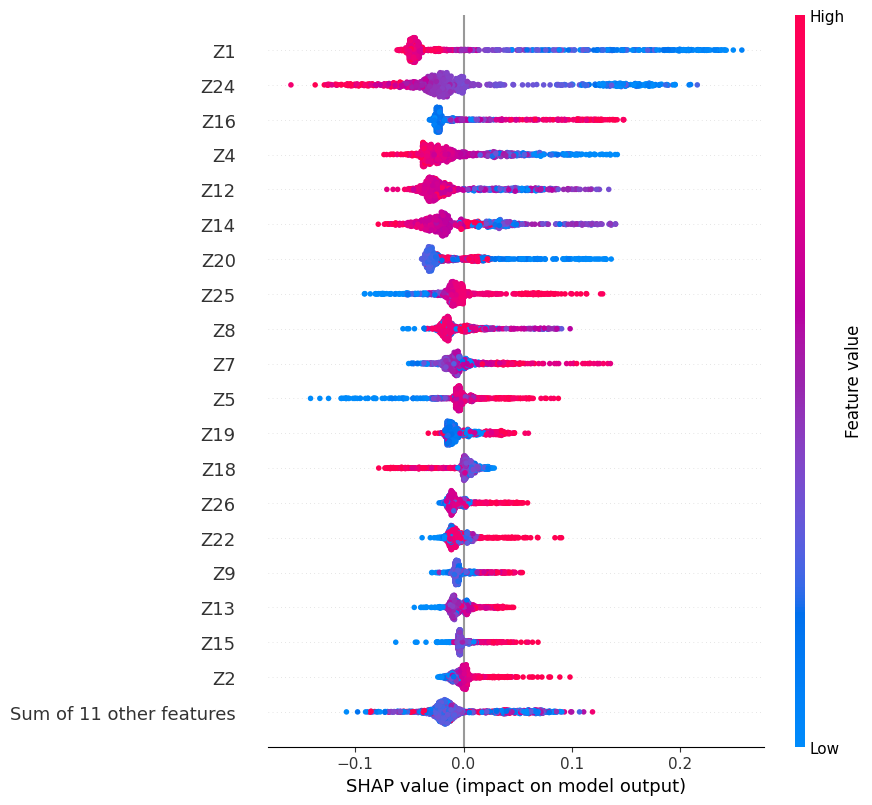

In [26]:
# SHAP explainability on combined DAE model
explainer = shap.Explainer(
    lambda X: clf_combined_dae.predict_proba(X)[:, 1],
    Z_tr,
    feature_names=[f"Z{i}" for i in range(Z_tr.shape[1])]
)

shap_values = explainer(Z_val)
shap.plots.beeswarm(shap_values, max_display=20)



This code extracts the gene contributions to a specific latent dimension from the trained DAE encoder.

* It retrieves the weight matrix from the encoder’s input layer to the bottleneck layer (latent_space), where rows correspond to genes and columns to latent dimensions.
* Selecting Z11 (latent dimension index 11), it ranks genes by the absolute magnitude of their weights in this dimension, indicating their influence on that latent feature.
* The top 10 genes for Z11 are identified.

This output provides biological interpretability by linking DAE latent features back to the most strongly associated genes.


In [27]:
# Get encoder weights from input to bottleneck
encoder_weights = enc_c.get_layer("latent_space").get_weights()[0]

# For example, top genes for Z11 (index 11)
z_index = 11
top_genes_idx = np.argsort(np.abs(encoder_weights[:, z_index]))[::-1][:10]
top_genes = adata_combined.var_names[top_genes_idx]
print("Top genes contributing to Z11:", top_genes)


Top genes contributing to Z11: Index(['OR2C1', 'NDUFS4', 'GNLY', 'SOHLH2', 'PIGL', 'CLDN3', 'KRT4', 'PECR',
       'HBB', 'CCL19'],
      dtype='object')


This code renders a SHAP waterfall for one validation cell, decomposing the model’s output from the baseline ≈0.30 into additive contributions of latent features. For this cell, the leading features (Z6, Z20, Z21, Z10, Z13, Z22, Z18, Z4, Z7) all push the prediction downward (e.g., Z6 ≈ −0.11), resulting in a final output near zero (i.e., very low tumor probability if computed in probability space).

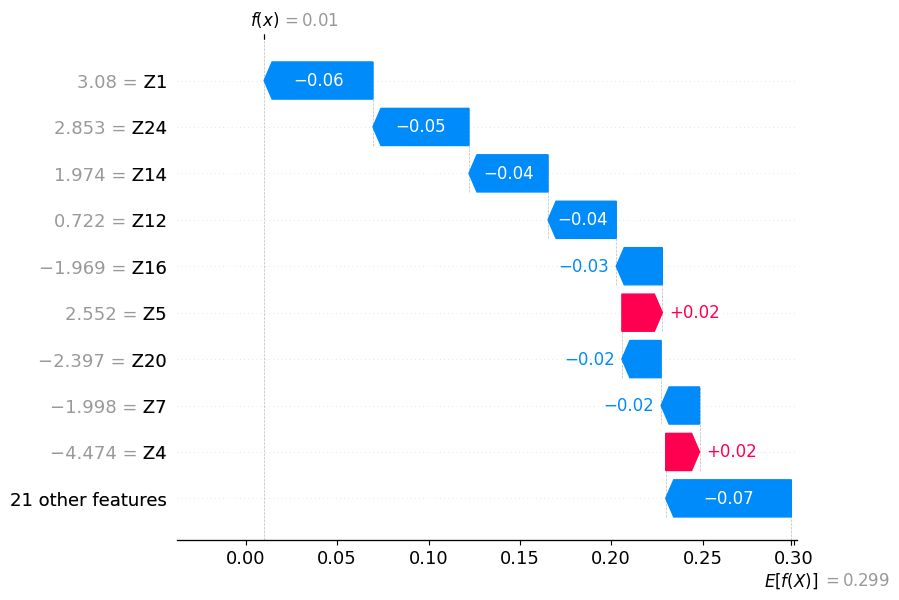

In [28]:
# SHAP waterfall plot for a specific cell in the validation set
shap.plots.waterfall(shap_values[0])  # First cell in validation set


This code identifies the top five most important latent features in the trained Random Forest model by analyzing feature importance scores. First, it generates feature names (Z0, Z1, ...) corresponding to the dimensions in the latent space. It then retrieves the model’s feature_importances_, associates these values with their respective feature names, and sorts them in descending order to highlight the most influential features. The results indicate that reported latent features contribute most to distinguishing tumor from non-tumor samples in the combined dataset. This ranking provides insight into which encoded features have the greatest impact on the model’s decision-making process.


In [29]:
# Analyze feature importances from Random Forest on DAE latent features

# Feature names
feature_names = [f"Z{i}" for i in range(X_train.shape[1])]

# Get feature importances
importances = clf_combined_dae.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    "Latent_Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(5).reset_index(drop=True)

# Display result
print("Top 5 Latent Features by Random Forest Importance:")
print(importance_df)




Top 5 Latent Features by Random Forest Importance:
  Latent_Feature  Importance
0            Z24    0.136249
1             Z1    0.094686
2             Z4    0.078899
3            Z12    0.071719
4            Z25    0.063259


This code maps the most important latent features from the trained Random Forest model to their top contributing genes using weights from the DAE encoder’s latent space layer. It begins by loading the trained encoder and combined scRNA-seq dataset, extracting gene names and the latent space weight matrix. The top latent features are selected based on prior Random Forest feature importance results. For each latent feature, the absolute weights are ranked, and the top 10 genes with the highest contributions are identified. The results are stored in a dictionary, converted into a DataFrame, and printed. This mapping links latent space dimensions back to biologically interpretable genes, aiding in understanding the model’s learned representations.

In [30]:
# Identify top genes contributing to key latent features (driven by importance_df)

# Load trained DAE encoder and combined AnnData
encoder_comb = joblib.load("dae_encoder_model.pkl")
adata_combined = anndata.read_h5ad("adata_combined.h5ad")

# Get gene names and latent layer weights
gene_names = adata_combined.var_names.to_list()
latent_weights = encoder_comb.get_layer("latent_space").get_weights()[0]  # shape: (num_genes, latent_dim)

# Use the Latent_Feature column from importance_df (e.g., ['Z27','Z3',...])
top_latent_features = importance_df["Latent_Feature"].tolist()

# Map each latent feature from importance_df to its top 10 genes
top_genes_per_latent = {}
for zname in top_latent_features:
    # parse index from 'Z##'
    idx = int(zname[1:])
    abs_weights = np.abs(latent_weights[:, idx])
    top_gene_idxs = np.argsort(abs_weights)[::-1][:10]
    top_genes_per_latent[zname] = [gene_names[i] for i in top_gene_idxs]

# Format into DataFrame (rows = rank 1..10, cols = latent features from importance_df)
top_genes_df = pd.DataFrame(top_genes_per_latent)
top_genes_df.index = [f"Rank_{i}" for i in range(1, 11)]

print("Top 10 genes contributing to each latent feature from importance_df:")
print(top_genes_df)

Top 10 genes contributing to each latent feature from importance_df:
            Z24      Z1         Z4      Z12        Z25
Rank_1    MED26   FOLR2    TMEM125    CLDN3  LINC00597
Rank_2     ECRP    MDS2     SLC3A2     AMPH      TNNT3
Rank_3    CCZ1B    PIGL  KRTAP19-8   WNT10B       MMP7
Rank_4   SOHLH2   UIMC1     NDUFS4     LRMP     MIR221
Rank_5   NDUFS4  SLC4A4       MDS2     VMO1       TAB2
Rank_6     COLQ  EDDM3B     TTTY14   CLEC5A      CLDN3
Rank_7    TNNT3  TCEAL2      OR5W2     GNLY  KRTAP13-1
Rank_8    GABRP  MIR221     ENTHD1    SFTA2   C1orf145
Rank_9    SFTA2  HIGD1B       E2F4     COMP  LINC00460
Rank_10      TF   TREM1       MMP2  FRMD8P1       MMP2


This code analyzes the trained Random Forest classifier’s latent feature importance and visualizes both the top features and their associated genes. It first loads the classifier, encoder, and a mapping of top genes for each latent feature. The model’s feature_importances_ are paired with latent feature names (Z, `Z1, …), sorted, and the top five are selected. A bar plot displays these top features by their mean decrease in impurity, revealing the most influential in predicting tumor versus non-tumor status. To further interpret these results, a heatmap shows the top 10 contributing genes for five key latent features, with ranks from 1 to 10. Together, these visualizations provide insights into which encoded features are most important for classification and the biological genes driving those features.


C:\Users\josha\AppData\Local\Temp\ipykernel_21016\1393907518.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=importance_df, x="Latent_Feature", y="Importance", palette="Blues_d")


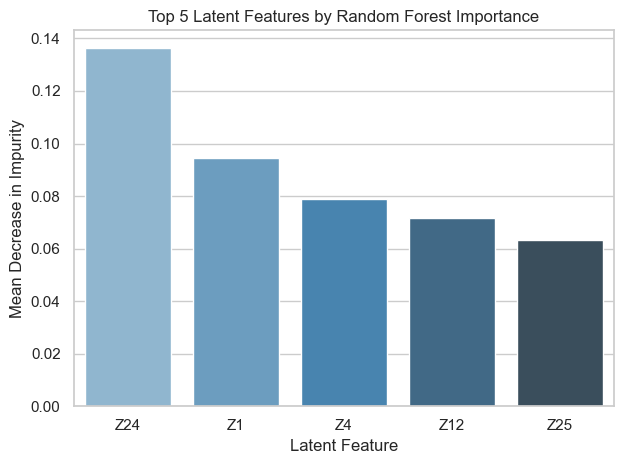

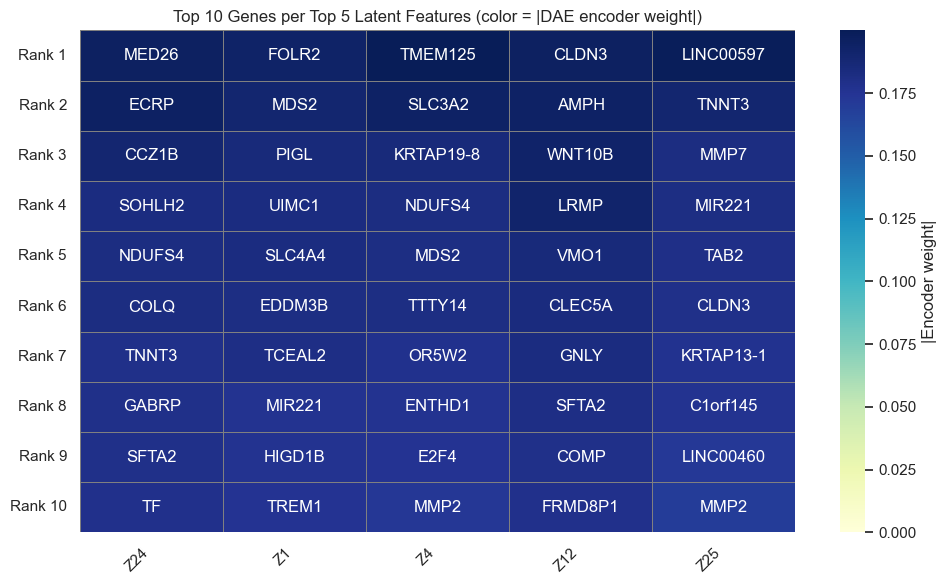

In [31]:
TOP_K_FEATURES = 5
TOP_N_GENES    = 10
LAYER_NAME     = "latent_space"

# Load models and data
clf = joblib.load("clf_combined_dae.pkl")
enc = joblib.load("dae_encoder_model.pkl")
adata = anndata.read_h5ad("adata_combined.h5ad")

# Random Forest feature importances
imp = pd.Series(clf.feature_importances_, index=[f"Z{i}" for i in range(len(clf.feature_importances_))])
importance_df = (imp.nlargest(TOP_K_FEATURES)
                   .rename_axis("Latent_Feature")
                   .reset_index(name="Importance"))
top_features = importance_df["Latent_Feature"].tolist()

# Bar plot of top latent features
sns.set(style="whitegrid")
ax = sns.barplot(data=importance_df, x="Latent_Feature", y="Importance", palette="Blues_d")
ax.set(title=f"Top {TOP_K_FEATURES} Latent Features by Random Forest Importance",
       xlabel="Latent Feature", ylabel="Mean Decrease in Impurity")
plt.tight_layout(); plt.show()

# Heatmap of top genes per top latent feature
W = enc.get_layer(LAYER_NAME).get_weights()[0]   # (num_genes, latent_dim)
genes = adata.var_names.to_numpy()

annot = pd.DataFrame(index=range(1, TOP_N_GENES+1))
weights_mat = np.zeros((TOP_N_GENES, len(top_features)), dtype=float)

for j, z in enumerate(top_features):
    li = int(z[1:])              # latent index from 'Z#'
    abs_w = np.abs(W[:, li])
    idx = np.argpartition(-abs_w, TOP_N_GENES-1)[:TOP_N_GENES]
    idx = idx[np.argsort(-abs_w[idx])]  # sort exact top-N
    annot[z] = genes[idx]
    weights_mat[:, j] = abs_w[idx]

# Heatmap plot
plt.figure(figsize=(max(10, 1.8*len(top_features)), 6))
ax = sns.heatmap(weights_mat, annot=annot.values, fmt="",
                 cmap="YlGnBu", cbar=True, vmin=0,
                 linewidths=0.5, linecolor="gray")
ax.collections[0].colorbar.set_label("|Encoder weight|")
ax.set_xticks(np.arange(len(top_features)) + 0.5)
ax.set_xticklabels(top_features, rotation=45, ha="right")
ax.set_yticks(np.arange(TOP_N_GENES) + 0.5)
ax.set_yticklabels([f"Rank {i}" for i in range(1, TOP_N_GENES+1)], rotation=0)
plt.title(f"Top {TOP_N_GENES} Genes per Top {len(top_features)} Latent Features (color = |DAE encoder weight|)")
plt.tight_layout(); plt.show()


The genes of interest were identified by mapping back from the most influential latent features in the denoising autoencoder. For each top latent, the encoder’s weight matrix was examined to extract the genes with the strongest contributions, and these candidates were further prioritized using model importance scores such as Random Forest feature weights and SHAP values. To add biological context, the code below queries the UniProt REST API to retrieve detailed annotations for each gene, including protein name, function, subcellular location, and organism. The results are compiled into a Pandas DataFrame and saved as uniprot_gene_annotations.csv. Several genes returned no matches, which were reported with warning messages, while successfully matched genes had their annotations saved for downstream interpretation.

In [32]:
# Annotate top genes via UniProt API

# Configurable parameters
TOP_K_FEATURES = 5            # number of RF-important latent features to use
TOP_N_GENES    = 10           # top genes to pull per latent
ENC_LATENT     = "latent_space"   # encoder latent layer name
HVG_FILTER     = True             # filter to HVGs list?
HVG_PATH       = "hvg_gene_list.txt"
UNIPROT_DELAY  = 0.5              # polite API delay (sec)
OUT_CSV        = "uniprot_gene_annotations.csv"

# UniProt query helper
def get_uniprot_data(genes):
    """Query UniProt (organism_id=9606) for gene symbols, return annotations DataFrame."""
    base_search, base_entry = "https://rest.uniprot.org/uniprotkb/search", "https://rest.uniprot.org/uniprotkb/"
    headers, sess, rows = {"Accept": "application/json"}, requests.Session(), []
    for g in genes:
        try:
            r = sess.get(base_search, headers=headers,
                         params={"query": f"({g}) AND organism_id:9606", "format": "json", "size": 1}, timeout=10)
            hit = (r.json().get("results") or [None])[0] if r.status_code == 200 else None
            if not hit: print(f"⚠️ No hit for {g}"); time.sleep(UNIPROT_DELAY); continue
            acc = hit["primaryAccession"]
            er  = sess.get(f"{base_entry}{acc}.json", headers=headers, timeout=10)
            if er.status_code != 200: print(f"⚠️ Failed entry for {g} ({acc})"); time.sleep(UNIPROT_DELAY); continue
            entry, comments = er.json(), er.json().get("comments", [])
            func = next((c["texts"][0]["value"] for c in comments if c.get("commentType")=="FUNCTION" and c.get("texts")), "")
            sublocs = sorted({loc.get("location",{}).get("value") for c in comments if c.get("commentType")=="SUBCELLULAR LOCATION"
                              for loc in c.get("subcellularLocations", []) if loc.get("location")})
            rows.append({
                "Gene": g, "Accession": acc,
                "Protein Name": entry.get("proteinDescription", {}).get("recommendedName", {}).get("fullName", {}).get("value", ""),
                "Function": func, "Subcellular Location": "; ".join(sublocs),
                "Organism": entry.get("organism", {}).get("scientificName", "")
            })
        except Exception as e:
            print(f"❌ {g}: {e}")
        time.sleep(UNIPROT_DELAY)
    return pd.DataFrame(rows)

# Load artifacts
clf, enc, adata = joblib.load("clf_combined_dae.pkl"), joblib.load("dae_encoder_model.pkl"), anndata.read_h5ad("adata_combined.h5ad")
try:
    W = enc.get_layer(ENC_LATENT).get_weights()[0]   # (genes × latent_dim)
except ValueError as e:
    raise RuntimeError(f"Layer '{ENC_LATENT}' not found in encoder.") from e

# Match RF importances to latent dim
genes_all, latent_dim, rf_dim = adata.var_names.to_numpy(), W.shape[1], len(clf.feature_importances_)
n_dims = min(latent_dim, rf_dim)
if latent_dim != rf_dim: print(f"⚠️ Dim mismatch: encoder={latent_dim}, RF={rf_dim} → using first {n_dims}")

# Top-K RF latents
imp = pd.Series(clf.feature_importances_[:n_dims], index=[f"Z{i}" for i in range(n_dims)])
top_feats = imp.nlargest(TOP_K_FEATURES).index

# Top-N genes per latent by absolute encoder weights
picked = []
for z in top_feats:
    i, aw = int(z[1:]), np.abs(W[:, int(z[1:])])
    idx = np.argpartition(-aw, TOP_N_GENES-1)[:TOP_N_GENES]
    picked.extend(genes_all[idx[np.argsort(-aw[idx])]])

# Deduplicate and clean gene list
genes_prog = pd.Series(pd.unique(pd.Series(picked, dtype=str))).dropna().astype(str).str.strip().tolist()
genes_prog = [g for g in genes_prog if g.lower() != "nan"]

# HVG filter
if HVG_FILTER:
    if Path(HVG_PATH).exists():
        hvg_set = set(pd.read_csv(HVG_PATH, header=None, dtype=str)[0].str.strip().str.upper())
        genes_prog = [g for g in genes_prog if g.upper() in hvg_set]
    else:
        print(f"⚠️ HVG list '{HVG_PATH}' not found; skipping HVG filter.")

# Remove common non-protein-coding names
NON_PROTEIN = re.compile(r"^(MIR|SNORD|SNORA|SCARNA|RNU|RNY|SNAR|LINC|LOC)\b", re.I)
genes_prog = [g for g in genes_prog if not NON_PROTEIN.match(g)]

print(f"🧬 Selected {len(genes_prog)} genes from {TOP_K_FEATURES} latents (top {TOP_N_GENES}/latent).")

# Annotate via UniProt
df = get_uniprot_data(genes_prog)
df.to_csv(OUT_CSV, index=False)
print(f"✅ Saved {len(df)} annotated genes → {OUT_CSV}")

# Display top 10 results
try:
    from IPython.display import display
    display(df[["Gene","Accession","Protein Name","Subcellular Location"]].head(10))
except Exception:
    print(df[["Gene","Accession","Protein Name","Subcellular Location"]].head(10).to_string(index=False))


🧬 Selected 43 genes from 5 latents (top 10/latent).
⚠️ No hit for MIR221
⚠️ No hit for TTTY14
⚠️ No hit for LINC00460
✅ Saved 40 annotated genes → uniprot_gene_annotations.csv


Gene   Accession                                       Protein Name  \
0   MED26      M0R064  Mediator of RNA polymerase II transcription su...   
1    ECRP      Q12762                                                      
2   CCZ1B      F8WD66                                                      
3  SOHLH2      Q9NX45  Spermatogenesis- and oogenesis-specific basic ...   
4  NDUFS4      H0Y9M8  NADH dehydrogenase [ubiquinone] iron-sulfur pr...   
5    COLQ  A0A0C4DGS2                                                      
6   TNNT3      H9KVA2                   Troponin T, fast skeletal muscle   
7   GABRP      O00591        Gamma-aminobutyric acid receptor subunit pi   
8   SFTA2      Q6UW10                    Surfactant-associated protein 2   
9      TF      P08709                             Coagulation factor VII   

                                Subcellular Location  
0                                            Nucleus  
1                      Cytoplasmic granule; Lysosome  
2                                                     
3                                 Cytoplasm; Nucleus  
4                       Mitochondrion inner membrane  
5                                                     
6                                                     
7                Apical cell membrane; Cell membrane  
8  Cytoplasmic vesicle, secretory vesicle; Golgi ...  
9                                           Secreted

This code performs functional enrichment analysis on a custom gene list using the gseapy Enrichr API.

It runs two separate analyses:

* GO Biological Process 2021 enrichment to identify overrepresented biological processes.
* KEGG 2021 Human pathway enrichment to find relevant signaling or metabolic pathways.

Both analyses are performed for human genes with a relaxed significance cutoff of 0.1 to capture more potential hits. The top 20 results from each analysis are saved to GO_BP_enrichment_top20.csv and KEGG_enrichment_top20.csv. The output confirms that enrichment completed successfully and results were stored for further review.


In [33]:
# Gene set enrichment analysis (GSEA) using gseapy on top genes from important latents

# Configuration: knobs for how many latent features and genes per latent to use
TOP_K_FEATURES = 5
TOP_N_GENES    = 10
LAYER_NAME     = "latent_space"

# Load trained artifacts: RF classifier on latent space, encoder model, and merged AnnData
clf   = joblib.load("clf_combined_dae.pkl")
enc   = joblib.load("dae_encoder_model.pkl")
adata = anndata.read_h5ad("adata_combined.h5ad")

# Rank latent dimensions (Z0..Zk) by RandomForest importance and take the top-K
imp = pd.Series(clf.feature_importances_, index=[f"Z{i}" for i in range(len(clf.feature_importances_))])
top_feats = imp.nlargest(TOP_K_FEATURES).index.tolist()

# Build a dynamic gene list by taking, for each selected latent Zi, the top-N genes by encoder weight
W = enc.get_layer(LAYER_NAME).get_weights()[0]
all_genes = adata.var_names.to_numpy()

# Aggregate top genes across all selected latents
gene_list = []
for z in top_feats:
    li = int(z[1:])
    aw = np.abs(W[:, li])
    idx = np.argpartition(-aw, TOP_N_GENES-1)[:TOP_N_GENES]
    idx = idx[np.argsort(-aw[idx])]
    gene_list.extend(all_genes[idx])

# Deduplicate while preserving order and coerce to strings (drop empties)
gene_list = list(dict.fromkeys([g for g in map(str, gene_list) if g]))

print(f"Using {len(gene_list)} genes from {TOP_K_FEATURES} latents for enrichment.")

# Run Enrichr (GO Biological Process, KEGG) via gseapy
go_results = gp.enrichr(
    gene_list=gene_list,
    gene_sets="GO_Biological_Process_2021",
    organism="Human",
    outdir="enrichr_go_results",
    no_plot=True,
    cutoff=0.1
)

kekk_results = gp.enrichr(
    gene_list=gene_list,
    gene_sets="KEGG_2021_Human",
    organism="Human",
    outdir="enrichr_kegg_results",
    no_plot=True,
    cutoff=0.1
)

# Persist the top 20 terms to CSV for downstream visualization/reporting
go_results.results.head(20).to_csv("GO_BP_enrichment_top20.csv", index=False)
kekk_results.results.head(20).to_csv("KEGG_enrichment_top20.csv", index=False)

print("GO and KEGG enrichment complete. Top results saved to CSV.")

Using 43 genes from 5 latents for enrichment.
GO and KEGG enrichment complete. Top results saved to CSV.


This code loads the top 20 GO Biological Process and KEGG Pathway enrichment results from CSV files and visualizes them as bar plots based on statistical significance. It first reads the enrichment data, sorts the terms by their adjusted p-values, and computes the -log10 transformation to highlight statistical strength. Using Seaborn, it generates horizontal bar plots for both GO terms and KEGG pathways, ranking them from most to least significant. Together, these visualizations provide a clear overview of the functional and pathway-level context of the gene list.


C:\Users\josha\AppData\Local\Temp\ipykernel_21016\487465395.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="-log10(padj)", y="Term", palette="viridis")


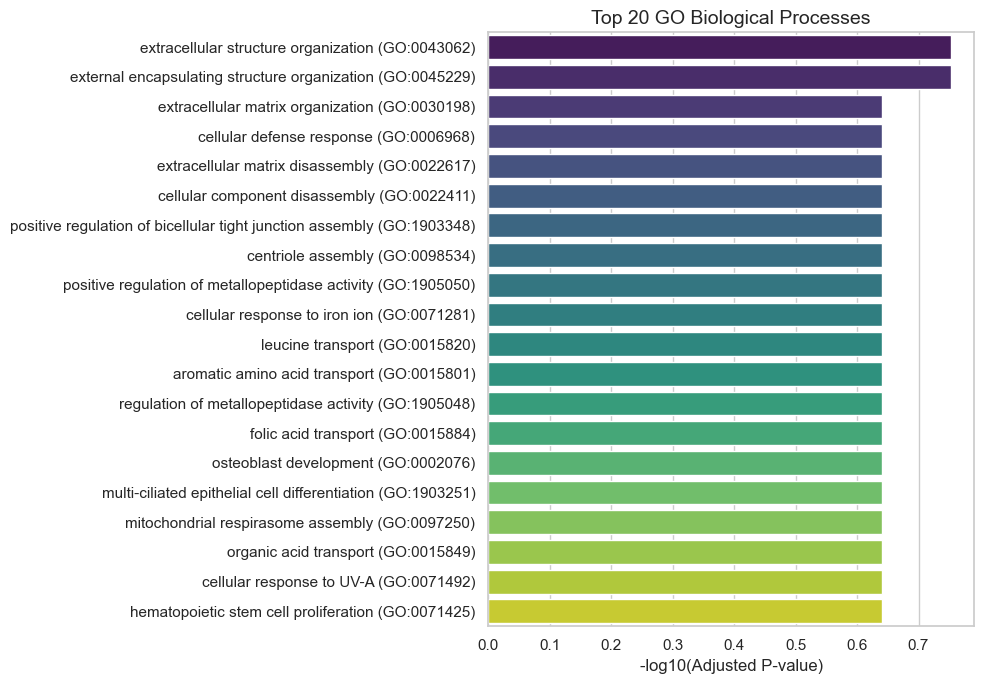

C:\Users\josha\AppData\Local\Temp\ipykernel_21016\487465395.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="-log10(padj)", y="Term", palette="viridis")


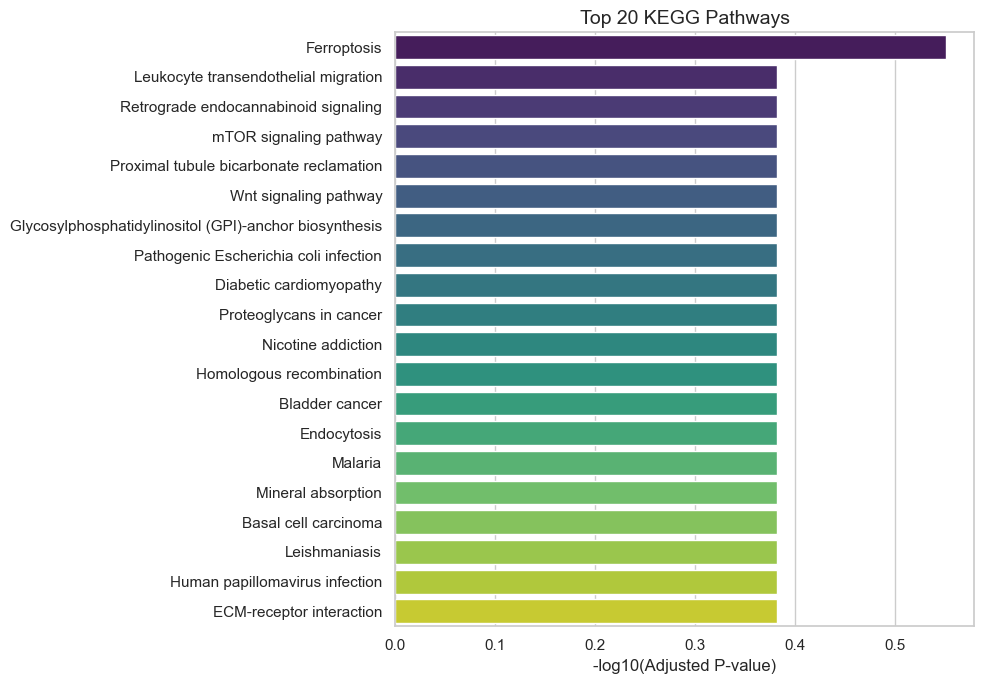

In [34]:
# GO and KEGG enrichment barplots

# Files in current directory
go_path = Path("GO_BP_enrichment_top20.csv")
kegg_path = Path("KEGG_enrichment_top20.csv")

# Optional: sanity check
for p in [go_path, kegg_path]:
    if not p.exists():
        raise FileNotFoundError(f"Couldn't find {p.resolve()} — check your working directory.")

go_df = pd.read_csv(go_path)
kegg_df = pd.read_csv(kegg_path)

# Plotting function
def plot_enrichment(df, title, top_n=20):
    df = df.sort_values(by="Adjusted P-value", ascending=True).head(top_n).copy()
    df["-log10(padj)"] = -np.log10(df["Adjusted P-value"])

    plt.figure(figsize=(10, 7))
    sns.barplot(data=df, x="-log10(padj)", y="Term", palette="viridis")
    plt.title(title, fontsize=14)
    plt.xlabel("-log10(Adjusted P-value)", fontsize=12)
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# Plot GO and KEGG barplots
plot_enrichment(go_df, "Top 20 GO Biological Processes")
plot_enrichment(kegg_df, "Top 20 KEGG Pathways")

This code creates and saves a background dataset of latent features for later use in model interpretation tasks such as SHAP analysis.

It starts with X_train (already transformed into the latent space), optionally downsamples it to 100 random samples to reduce computational cost, and then saves the resulting array as latent_background.pkl using joblib. The final saved dataset contains 100 samples with 30 latent features each, providing a manageable yet representative subset for background reference in explainability workflows.


In [35]:
# Assume X_train is already latent
latent_background = X_train.copy()

# Subsample
np.random.seed(42)
if latent_background.shape[0] > 100:
    idx = np.random.choice(latent_background.shape[0], size=100, replace=False)
    latent_background = latent_background[idx]

# Save
joblib.dump(latent_background, "latent_background.pkl")
print("Saved latent_background.pkl with shape:", latent_background.shape)


Saved latent_background.pkl with shape: (100, 30)
